In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
import os
from tqdm import tqdm
from sklearn.manifold import TSNE
np.random.seed(422)

Loading data below

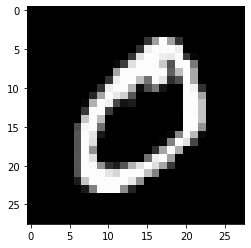

In [2]:
path = os.getcwd()

# train data
data = MNIST(path, train=True, download=True)
plt.imshow(np.array(data.__getitem__(1)[0].getdata()).reshape([28,28]), cmap='gray')
required_indices = []
for i in range(10):
    counter = 0
    inds = []
    j = 0
    while j < 100:
        if data.__getitem__(counter)[1] == i:
            inds.append(counter)
            j += 1
        counter += 1
    required_indices.append(inds)
dat = np.zeros([1000, 1, 28, 28])
labs = []
for i in range(10):
    for j in range(100):
        labs.append(i)
        dat[100*i+j, :, :, :] = np.array(data.__getitem__(required_indices[i][j])[0].getdata()).reshape([28,28])/255
labs = np.array(labs)

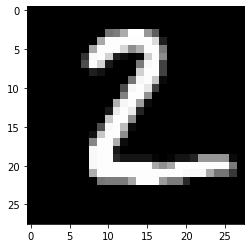

In [3]:
# test data
data = MNIST(path, train=False, download=True)
plt.imshow(np.array(data.__getitem__(1)[0].getdata()).reshape([28,28]), cmap='gray')
required_indices = []
for i in range(10):
    counter = 0
    inds = []
    j = 0
    while j < 10:
        if data.__getitem__(counter)[1] == i:
            inds.append(counter)
            j += 1
        counter += 1
    required_indices.append(inds)
test = np.zeros([100, 1, 28, 28])
test_labs = []
for i in range(10):
    for j in range(10):
        test_labs.append(i)
        test[10*i+j, :, :, :] = np.array(data.__getitem__(required_indices[i][j])[0].getdata()).reshape([28,28])/255
test_labs = np.array(test_labs)

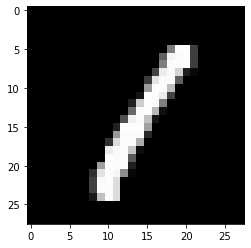

In [4]:
plt.imshow(np.transpose(dat[100, :, :, :], (1,2,0)), cmap='gray')
plt.show()

# Question 3-5
Below we implement the Backprop algorithm.

In [5]:
def relu(img):
    return np.maximum(0,img)

In [6]:
def convolution(img, kernel, bias, stride, non_linearity, padding=0):
    K, _, _ = np.shape(kernel)
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([(H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    kernel = kernel[::-1, ::-1, :]

    horizontal_flip = img[:, :, ::-1]
    vertical_flip = img[:, ::-1, :]
    full_flip = img[:, ::-1, ::-1]
    padded_img = np.zeros([C, H+2*padding, W+2*padding])
    padded_img[:, padding:H+padding, padding:W+padding] = img #center
    padded_img[:, 0:padding, 0:padding] = full_flip[:, -padding:, -padding:] #top left corner
    padded_img[:, 0:padding, padding:W+padding] = vertical_flip[:, -padding:, :] #upper horizontal
    padded_img[:, padding:H+padding, 0:padding] = horizontal_flip[:, :, -padding:] #left vertical
    padded_img[:, -padding:, 0:padding] = full_flip[:, 0:padding, -padding:] #lower left corner
    padded_img[:, 0:padding, -padding:] = full_flip[:, -padding:, 0:padding] #upper right corner
    padded_img[:, -padding:, padding:W+padding] = vertical_flip[:, 0:padding, :] #lower horizontal
    padded_img[:, padding:H+padding, -padding:] = horizontal_flip[:, :, 0:padding] #right vertical
    padded_img[:, -padding:, -padding:] = full_flip[:, 0:padding, 0:padding] #lower right corner

    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m,n] = np.sum(padded_img[:, stride*m:stride*m+K, stride*n:stride*n+K]*np.transpose(kernel, (2,1,0)))
    return non_linearity(out_+bias)

def conv_backward(img, kernel, stride, padding, grads, out):
    grads[out==0] = 0
    w_grad = np.zeros_like(kernel)
    K, _, _ = np.shape(kernel)
    b_grad = np.sum(grads)
    C, H, W = img.shape
    kernel = kernel[::-1, ::-1, :]

    horizontal_flip = img[:, :, ::-1]
    vertical_flip = img[:, ::-1, :]
    full_flip = img[:, ::-1, ::-1]
    padded_img = np.zeros([C, H+2*padding, W+2*padding])
    padded_img[:, padding:H+padding, padding:W+padding] = img #center
    padded_img[:, 0:padding, 0:padding] = full_flip[:, -padding:, -padding:] #top left corner
    padded_img[:, 0:padding, padding:W+padding] = vertical_flip[:, -padding:, :] #upper horizontal
    padded_img[:, padding:H+padding, 0:padding] = horizontal_flip[:, :, -padding:] #left vertical
    padded_img[:, -padding:, 0:padding] = full_flip[:, 0:padding, -padding:] #lower left corner
    padded_img[:, 0:padding, -padding:] = full_flip[:, -padding:, 0:padding] #upper right corner
    padded_img[:, -padding:, padding:W+padding] = vertical_flip[:, 0:padding, :] #lower horizontal
    padded_img[:, padding:H+padding, -padding:] = horizontal_flip[:, :, 0:padding] #right vertical
    padded_img[:, -padding:, -padding:] = full_flip[:, 0:padding, 0:padding] #lower right corner
    out_ = np.zeros_like(padded_img)

    for m in range(grads.shape[0]):
        for n in range(grads.shape[1]):
            out_[:, stride*m:stride*m+K, stride*n:stride*n+K] += grads[m,n]*np.transpose(kernel, (2,1,0))
            w_grad += np.transpose(grads[m,n]*padded_img[:, stride*m:stride*m+K, stride*n:stride*n+K], (2,1,0))[::-1, ::-1, :]

    final_grads = np.zeros_like(img)
    horizontal_flip = out_[:, :, ::-1]
    vertical_flip = out_[:, ::-1, :]
    full_flip = out_[:, ::-1, ::-1]
    final_grads += out_[:, padding:H+padding, padding:W+padding] #center
    final_grads[:, :, 0:padding] += horizontal_flip[:, padding:H+padding, -padding:] #left vertical
    final_grads[:, 0:padding, 0:padding] += full_flip[:, -padding:, -padding:] #upper left corner
    final_grads[:, 0:padding, :] += vertical_flip[:, -padding:, padding:W+padding] #upper horizontal
    final_grads[:, 0:padding, -padding:] += full_flip[:, -padding:, 0:padding] #top right corner
    final_grads[:, :, -padding:] += horizontal_flip[:, padding:H+padding, 0:padding] #right vertical
    final_grads[:, -padding:, 0:padding] += full_flip[:, 0:padding, -padding:] #lower left corner
    final_grads[:, -padding:, :] += vertical_flip[:, 0:padding, padding:W+padding] #lower horizontal
    final_grads[:, -padding:, -padding:] += full_flip[:, 0:padding, 0:padding] #lower right corner

    return final_grads, w_grad, b_grad

In [7]:
def pool(inp, pool_func, size, stride):
    H, W = np.shape(inp)
    out_ = np.zeros([(H-size)//stride+1, (W-size)//stride+1])
    for m in range(out_.shape[0]):
        for n in range(out_.shape[1]):
            out_[m, n] = pool_func(inp[stride*m:stride*m+size, stride*n:stride*n+size])
    return out_

def max_pool(inp):
    return np.max(inp)

def pool_back(inp, size, grads, stride):
    out_ = np.zeros_like(inp)
    for m in range(grads.shape[0]):
        for n in range(grads.shape[1]):
            tmp = np.argmax(inp[stride*m:stride*m+size, stride*n:stride*n+size])
            out_[stride*m+tmp//size, stride*n+tmp%size] += grads[m,n]
    return out_

In [8]:
def convolution_layer(img, kernels, bias, stride, non_linearity, padding=0):
    out_channels, K, _, _ = kernels.shape
    padding = int(padding)
    C, H, W = np.shape(img)
    out_ = np.zeros([out_channels, (H-K+2*padding)//stride + 1, (W-K+2*padding)//stride + 1])
    for h in range(out_channels):
        out_[h, :, :] = convolution(img, kernels[h, :, :, :], bias[h], stride, non_linearity, padding)
    return out_

def conv_layer_back(img, kernels, stride, padding, grads, out):
    out_ = np.zeros_like(img)
    w_grad = np.zeros_like(kernels)
    b_grad = np.zeros(out.shape[0])
    for h in range(kernels.shape[0]):
        tmp = conv_backward(img, kernels[h, :, :, :], stride, padding, grads[h, :, :], out[h, :, :])
        out_ += tmp[0]
        w_grad[h, :, :, :] = tmp[1]
        b_grad[h] = tmp[2]
    return w_grad, b_grad, out_

In [9]:
def pooling_layer(inp, pool_func, size, stride):
    C, H, W = np.shape(inp)
    out_ = np.zeros([C, (H-size)//stride+1, (W-size)//stride+1])
    for h in range(C):
        out_[h, :, :] = pool(inp[h, :, :], pool_func, size, stride)
    return out_

def pool_layer_back(inp, size, grads, stride):
    out_ = np.zeros_like(inp)
    for h in range(inp.shape[0]):
        out_[h, :, :] = pool_back(inp[h, :, :], size, grads[h, :, :], stride)
    return out_

In [10]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

class Mlp:
    def __init__(self, in_size, hid_size, out_size):
        self.weights = []
        self.bias = []
        hid_size = [in_size]+hid_size+[out_size]
        for h in range(len(hid_size)-1):
            self.weights.append(np.random.normal(0, np.sqrt(2/hid_size[h]), [hid_size[h], hid_size[h+1]]))
            self.bias.append(np.random.normal(0, np.sqrt(2/hid_size[h]), hid_size[h+1]))

    def forward(self, x, non_linearity):
        cache_ = []
        for h in range(len(self.weights)):
            x = non_linearity(x)@self.weights[h]+self.bias[h]
            cache_.append(x)
        x = softmax(x)
        return x, cache_

    def backward(self, grad, cash, inps):
        w_grad = []
        b_grad = []
        cash = [inps]+cash
        for h in range(len(cash)-1, 0, -1):
            w_grad.append(relu(cash[h-1])[:, np.newaxis]*grad)
            b_grad.append(grad)
            grad = np.sum(self.weights[h-1]*grad, axis=1)
            grad[cash[h-1]<=0] = 0
        w_grad.reverse()
        b_grad.reverse()
        return w_grad, b_grad, grad

In [11]:
class CNN:
    def __init__(self, n_classes, in_size, hid_size):
        self.mlp = Mlp(in_size, hid_size, n_classes)
        self.conv1_weights = np.random.normal(0, np.sqrt(2/100), [4, 5, 5, 1])
        self.conv2_weights = np.random.normal(0, np.sqrt(2/100), [4, 5, 5, 4])
        self.conv1_bias = np.random.normal(0, np.sqrt(2/100), 4)
        self.conv2_bias = np.random.normal(0, np.sqrt(2/100), 4)

    def forward(self, images):
        out = []
        for h in range(images.shape[0]):
            out.append(convolution_layer(images[h, :, :, :], self.conv1_weights, self.conv1_bias, 1, relu, 2))
        out2 = []
        for h in range(images.shape[0]):
            out2.append(pooling_layer(out[h], max_pool, 2, 2))
        out3 = []
        for h in range(images.shape[0]):
            out3.append(convolution_layer(out2[h], self.conv2_weights, self.conv2_bias, 1, relu, 2))
        out4 = []
        for h in range(images.shape[0]):
            out4.append(pooling_layer(out3[h], max_pool, 2, 2).flatten())
        out5 = []
        mlp_cache = []
        for h in range(images.shape[0]):
            tmp = self.mlp.forward(out4[h], relu)
            out5.append(tmp[0])
            mlp_cache.append(tmp[1])
        return np.array(out5), (out, out2, out3, out4, mlp_cache)

    def backward(self, grads, cash, images):
        grds = []
        mlp_grads = []
        mlp_bias_grad = []
        for h in range(len(self.mlp.weights)):
            mlp_grads.append(np.zeros_like(self.mlp.weights[h]))
            mlp_bias_grad.append(np.zeros_like(self.mlp.bias[h]))
        for h in range(grads.shape[0]):
            tmp = self.mlp.backward(grads[h, :], cash[-1][h], cash[-2][h])
            for g in range(len(self.mlp.weights)):
                mlp_grads[g] += tmp[0][g]
                mlp_bias_grad[g] += tmp[1][g]
            grds.append(tmp[2])
        for h in range(len(self.mlp.weights)):
            mlp_grads[h] /= grads.shape[0]
            mlp_bias_grad[h] /= grads.shape[0]
        for h in range(grads.shape[0]):
            grds[h] = grds[h].reshape([4, 7, 7])
        for h in range(grads.shape[0]):
            grds[h] = pool_layer_back(cash[2][h], 2, grds[h], 2)
        conv2_grads = np.zeros_like(self.conv2_weights)
        conv2_bias_grads = np.zeros_like(self.conv2_bias)
        for h in range(grads.shape[0]):
            tmp = conv_layer_back(cash[1][h], self.conv2_weights, 1, 2, grds[h], cash[2][h])
            conv2_grads += tmp[0]
            conv2_bias_grads += tmp[1]
            grds[h] = tmp[2]
        conv2_grads /= grads.shape[0]
        conv2_bias_grads /= grads.shape[0]
        for h in range(grads.shape[0]):
            grds[h] = pool_layer_back(cash[0][h], 2, grds[h], 2)
        conv1_grads = np.zeros_like(self.conv1_weights)
        conv1_bias_grads = np.zeros_like(self.conv1_bias)
        for h in range(grads.shape[0]):
            tmp = conv_layer_back(images[h, :, :, :], self.conv1_weights, 1, 2, grds[h], cash[0][h])
            conv1_grads += tmp[0]
            conv1_bias_grads += tmp[1]
            grds[h] = tmp[2]
        conv1_grads /= grads.shape[0]
        conv1_bias_grads /= grads.shape[0]

        return conv1_grads, conv1_bias_grads, conv2_grads, conv2_bias_grads, mlp_grads, mlp_bias_grad

In [12]:
model = CNN(10, 14*14, [49])
model.forward(dat[1:2])[0]

array([[0.05138995, 0.07705984, 0.04876247, 0.03376021, 0.0712954 ,
        0.18864189, 0.20653034, 0.06915848, 0.1716346 , 0.08176682]])

Below we implement Cross entropy loss function, accuracy and Stochastic gradient descent algorithm.

In [13]:
def accuracy(true, predicted):
    return np.mean(true==np.argmax(predicted, axis=1))

In [14]:
def CrossEntropyLoss(true, predicted):
    return np.mean(-np.log2(predicted[np.arange(len(true)), true]))

In [15]:
def sgd(grads, learning_rate):
    model.conv1_weights -= learning_rate*grads[0]
    model.conv1_bias -= learning_rate*grads[1]
    model.conv2_weights -= learning_rate*grads[2]
    model.conv2_bias -= learning_rate*grads[3]
    for h in range(len(grads[4])):
        model.mlp.weights[h] -= learning_rate*grads[4][h]
        model.mlp.bias[h] -= learning_rate*grads[5][h]

Below we train the CNN model using stochastic gradient descent. We experiment with batch size 5 and 50. We also visualize the activations after training on first and last epochs. I have chosen three images and visualized the activations after first convolution layer, first pooling layer and second convolution layer. So in total, 36 images are visualised after training on first epoch. After that, you can see the TSNE plot of bottleneck layer outputs. After that, another 36 images for activation maps after training on final epoch. Then you can see TSNE plot. Then you can see the plot of errors (cross-entropy error). Accuracy is reported after every epoch.

Currently training on epoch: 0


100%|██████████| 200/200 [01:27<00:00,  2.29it/s]


Train accuracy = 0.147
Test accuracy = 0.14


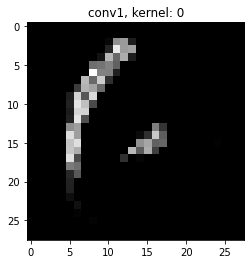

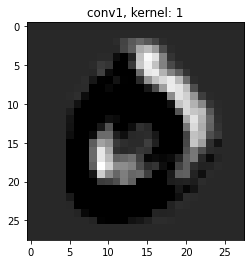

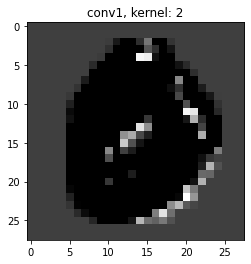

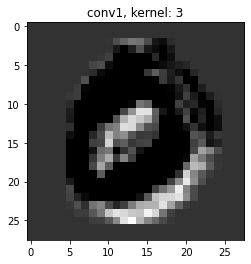

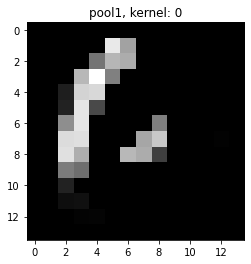

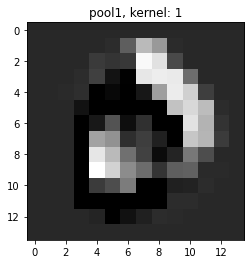

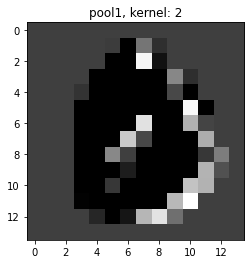

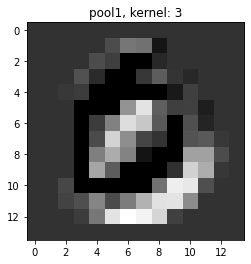

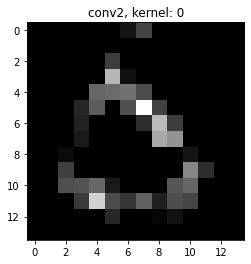

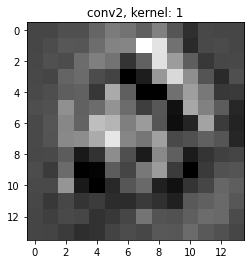

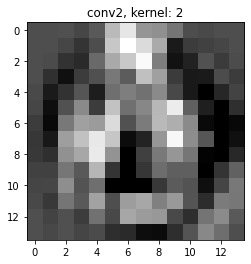

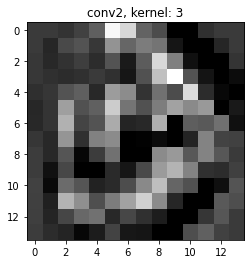

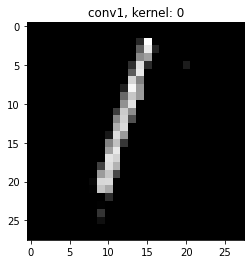

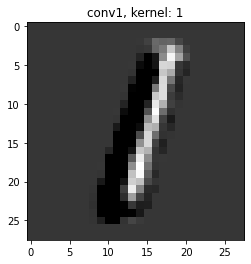

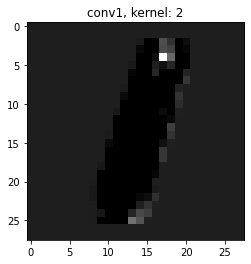

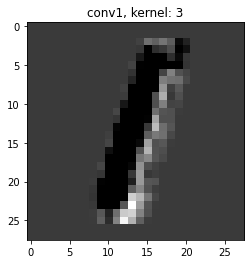

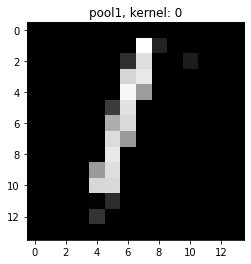

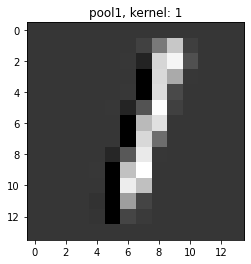

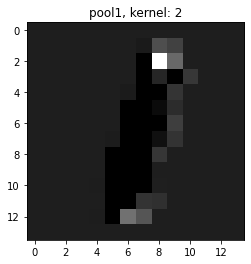

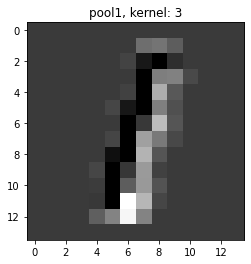

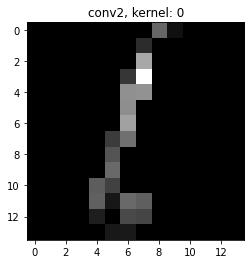

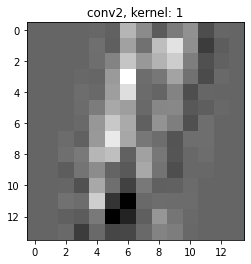

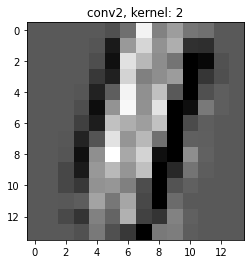

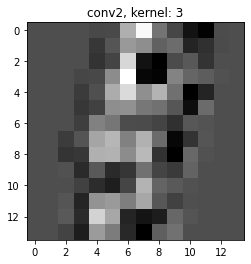

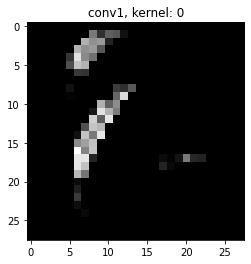

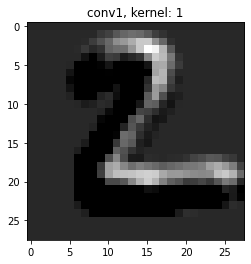

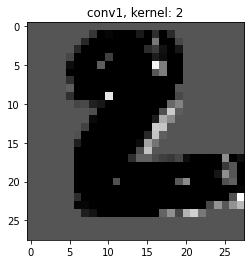

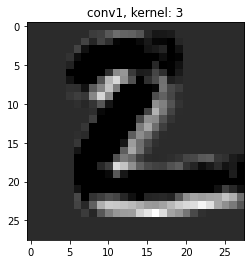

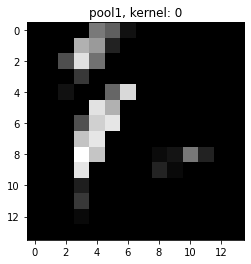

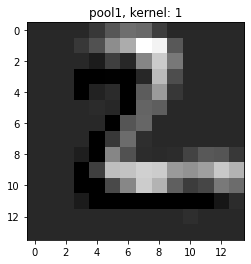

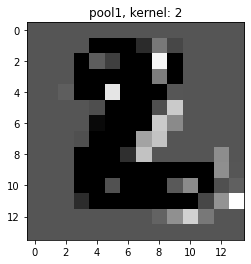

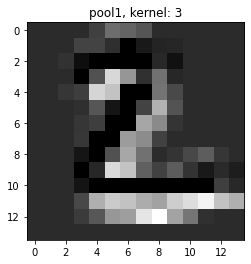

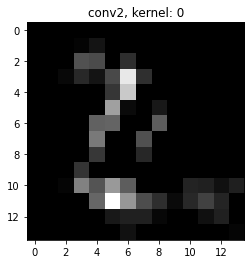

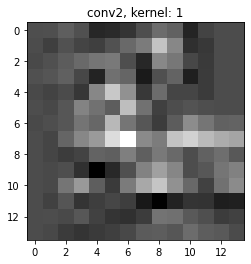

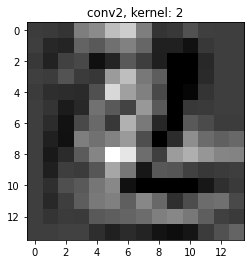

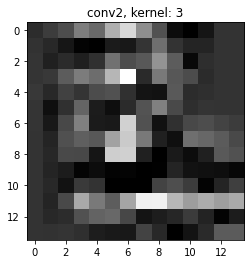

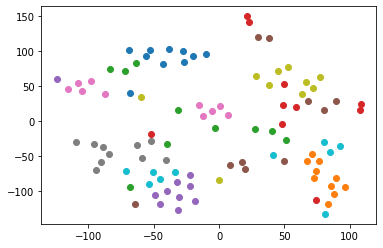

Currently training on epoch: 1


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


Train accuracy = 0.256
Test accuracy = 0.25
Currently training on epoch: 2


100%|██████████| 200/200 [01:22<00:00,  2.44it/s]


Train accuracy = 0.354
Test accuracy = 0.31
Currently training on epoch: 3


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.423
Test accuracy = 0.41
Currently training on epoch: 4


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.49
Test accuracy = 0.46
Currently training on epoch: 5


100%|██████████| 200/200 [01:21<00:00,  2.44it/s]


Train accuracy = 0.533
Test accuracy = 0.48
Currently training on epoch: 6


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.614
Test accuracy = 0.52
Currently training on epoch: 7


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.674
Test accuracy = 0.58
Currently training on epoch: 8


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.731
Test accuracy = 0.54
Currently training on epoch: 9


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.767
Test accuracy = 0.65
Currently training on epoch: 10


100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


Train accuracy = 0.79
Test accuracy = 0.7
Currently training on epoch: 11


100%|██████████| 200/200 [01:21<00:00,  2.44it/s]


Train accuracy = 0.831
Test accuracy = 0.71
Currently training on epoch: 12


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.843
Test accuracy = 0.76
Currently training on epoch: 13


100%|██████████| 200/200 [01:22<00:00,  2.42it/s]


Train accuracy = 0.858
Test accuracy = 0.79
Currently training on epoch: 14


100%|██████████| 200/200 [01:21<00:00,  2.44it/s]


Train accuracy = 0.871
Test accuracy = 0.82


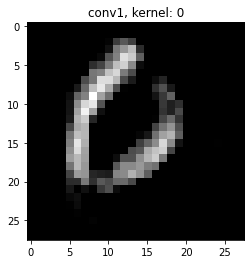

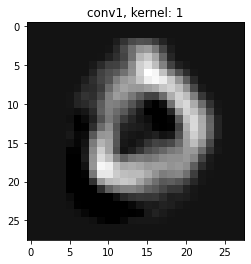

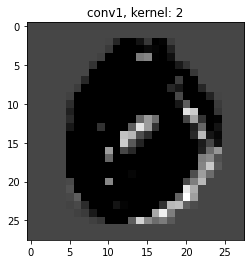

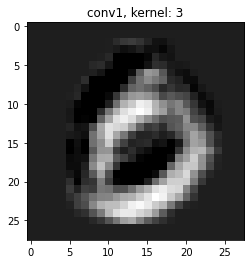

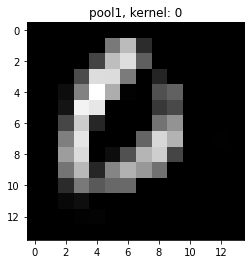

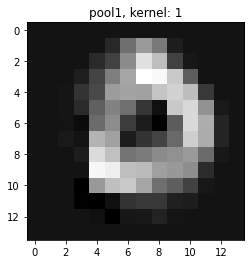

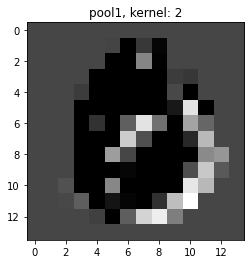

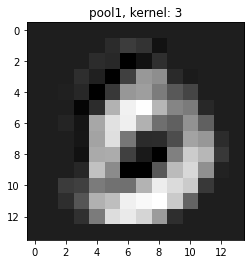

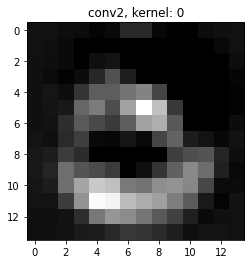

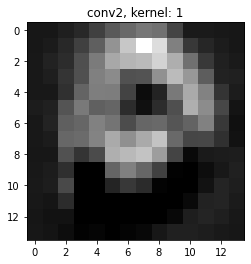

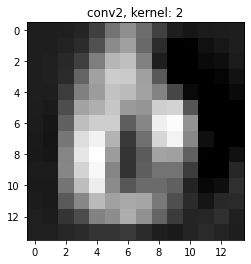

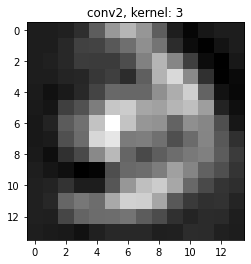

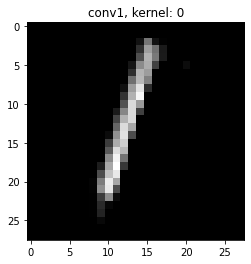

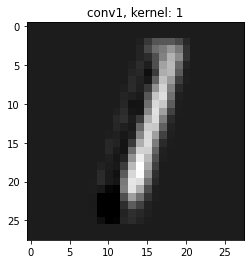

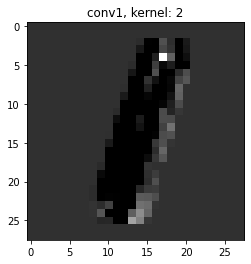

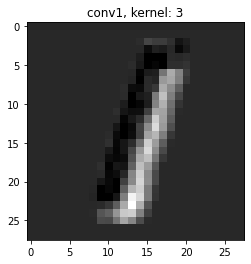

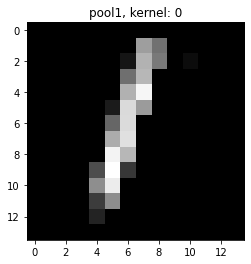

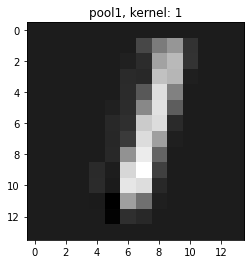

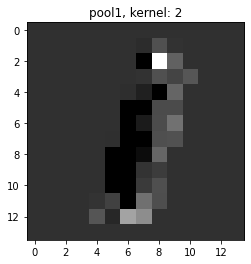

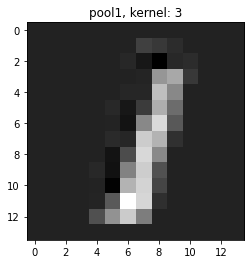

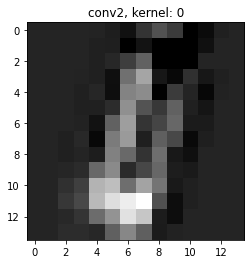

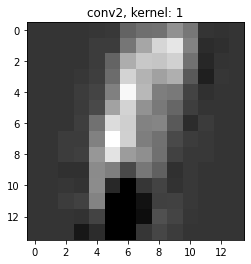

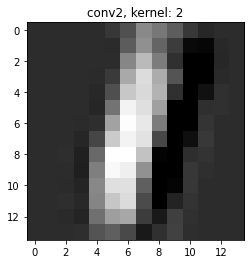

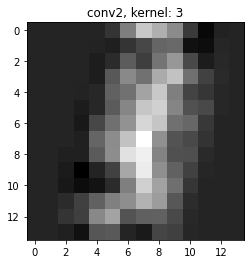

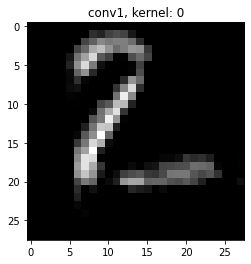

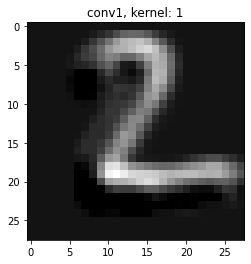

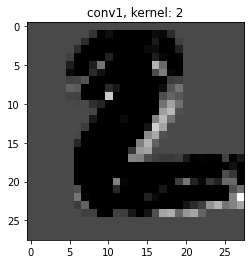

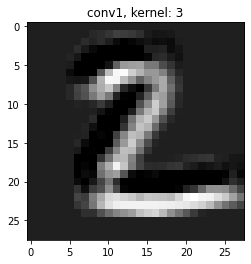

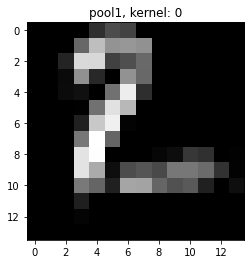

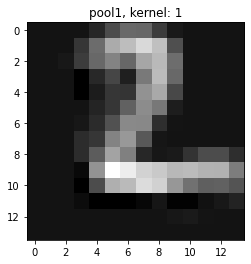

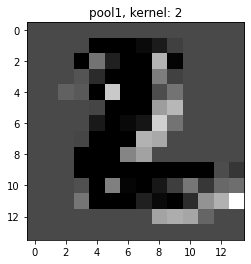

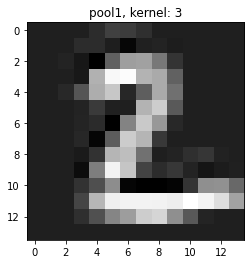

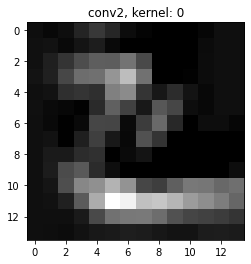

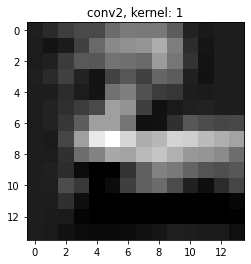

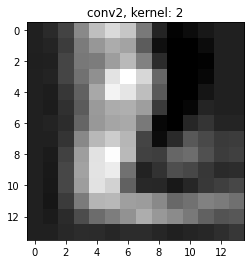

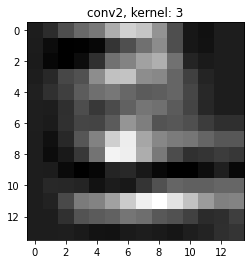

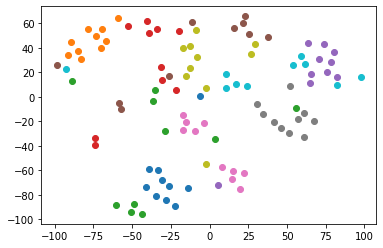

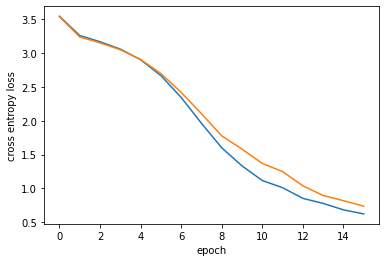

In [16]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 5
lr = 0.001

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        sgd(gradients, lr)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0


100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


Train accuracy = 0.079
Test accuracy = 0.06


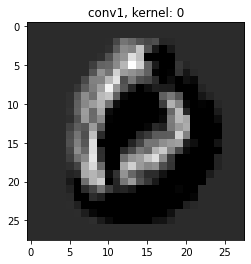

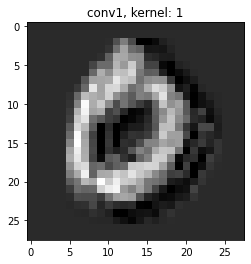

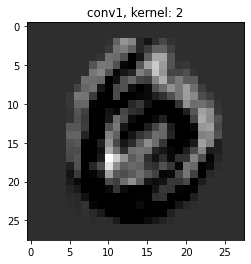

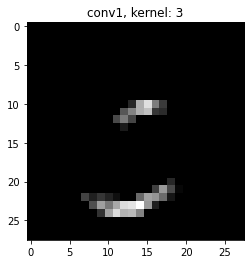

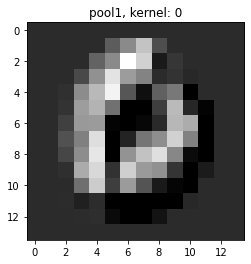

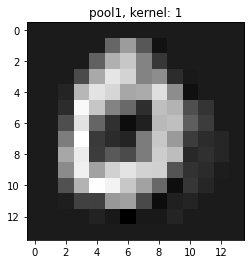

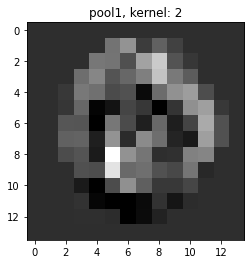

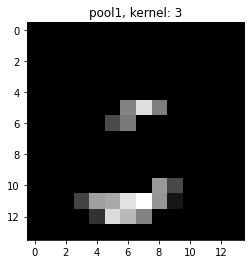

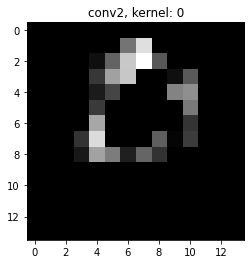

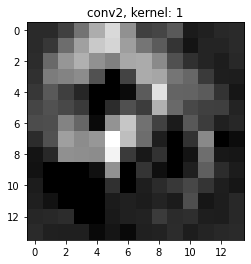

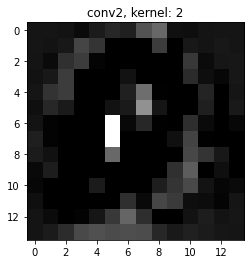

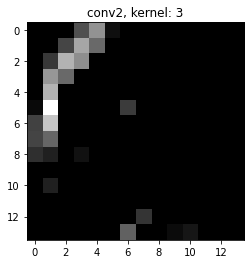

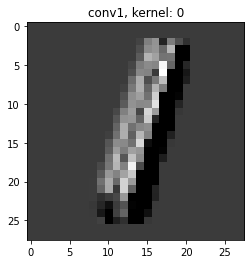

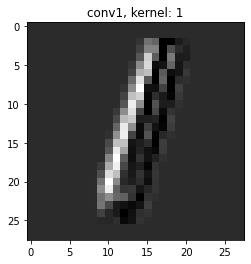

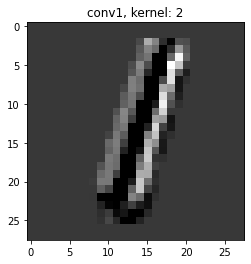

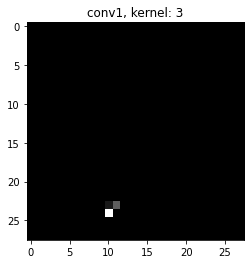

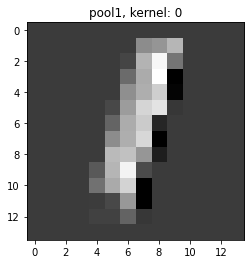

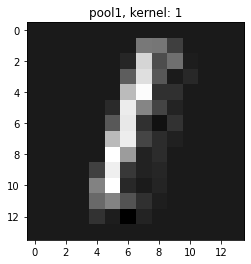

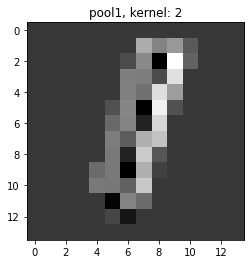

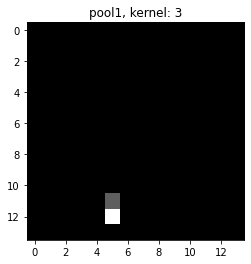

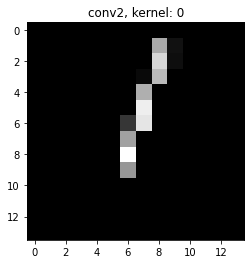

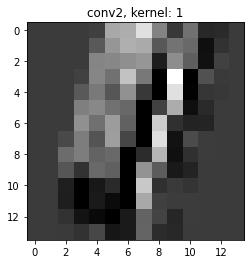

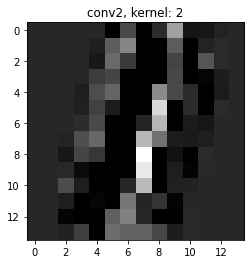

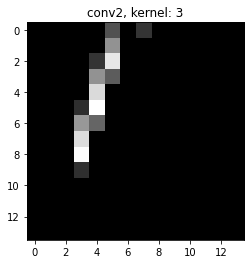

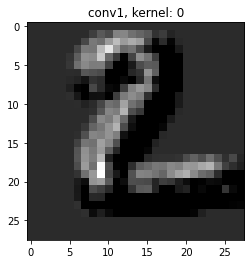

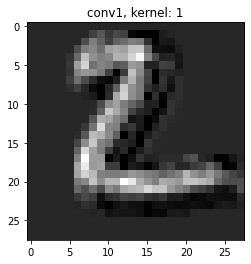

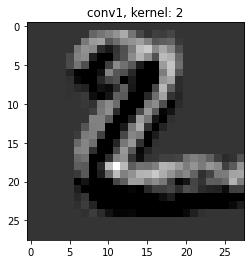

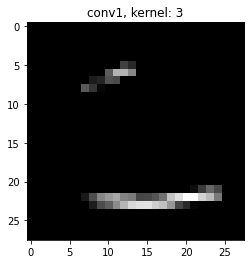

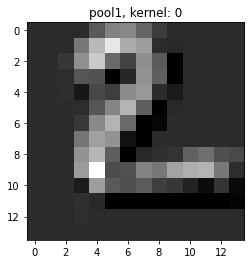

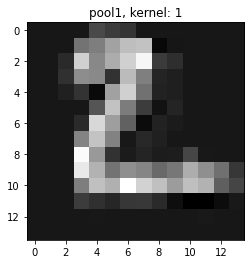

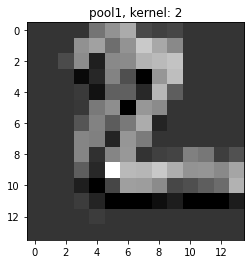

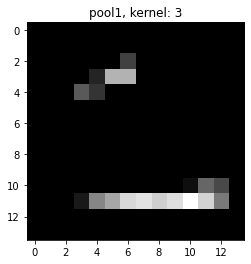

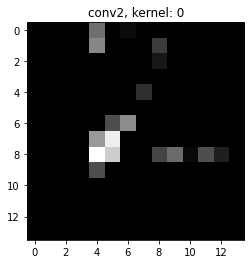

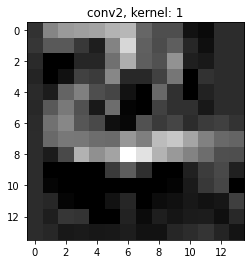

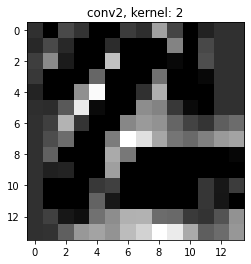

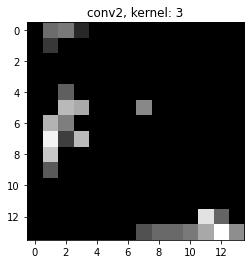

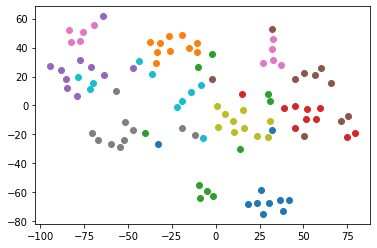

Currently training on epoch: 1


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


Train accuracy = 0.083
Test accuracy = 0.07
Currently training on epoch: 2


100%|██████████| 20/20 [01:16<00:00,  3.82s/it]


Train accuracy = 0.088
Test accuracy = 0.1
Currently training on epoch: 3


100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


Train accuracy = 0.089
Test accuracy = 0.1
Currently training on epoch: 4


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


Train accuracy = 0.089
Test accuracy = 0.1
Currently training on epoch: 5


100%|██████████| 20/20 [01:24<00:00,  4.21s/it]


Train accuracy = 0.092
Test accuracy = 0.1
Currently training on epoch: 6


100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


Train accuracy = 0.092
Test accuracy = 0.1
Currently training on epoch: 7


100%|██████████| 20/20 [01:18<00:00,  3.92s/it]


Train accuracy = 0.093
Test accuracy = 0.1
Currently training on epoch: 8


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Train accuracy = 0.095
Test accuracy = 0.1
Currently training on epoch: 9


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Train accuracy = 0.096
Test accuracy = 0.1
Currently training on epoch: 10


100%|██████████| 20/20 [01:21<00:00,  4.10s/it]


Train accuracy = 0.098
Test accuracy = 0.1
Currently training on epoch: 11


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Train accuracy = 0.1
Test accuracy = 0.1
Currently training on epoch: 12


100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


Train accuracy = 0.101
Test accuracy = 0.1
Currently training on epoch: 13


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Train accuracy = 0.103
Test accuracy = 0.1
Currently training on epoch: 14


100%|██████████| 20/20 [01:16<00:00,  3.83s/it]


Train accuracy = 0.101
Test accuracy = 0.1


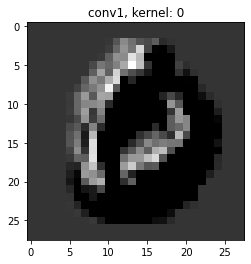

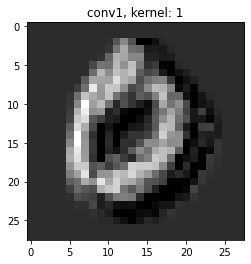

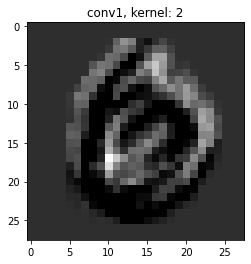

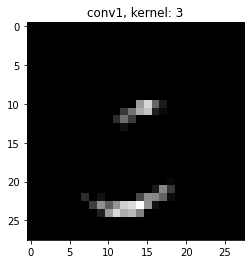

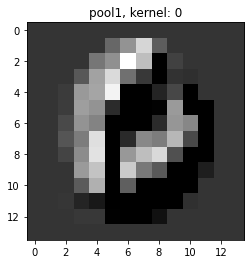

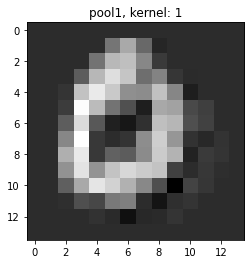

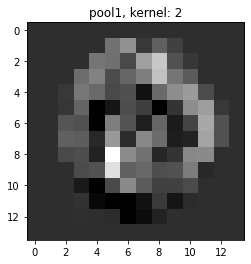

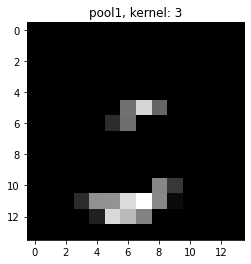

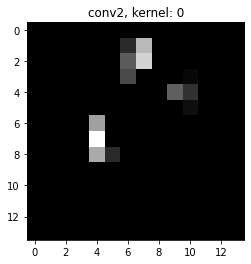

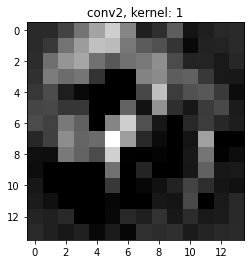

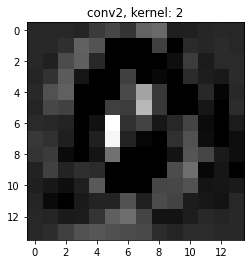

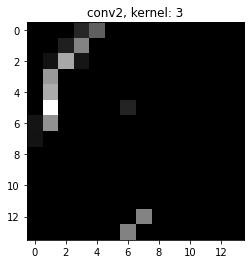

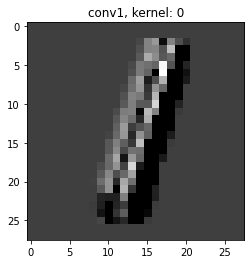

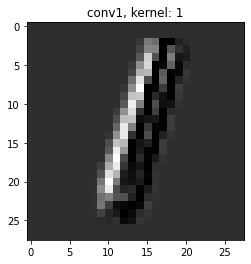

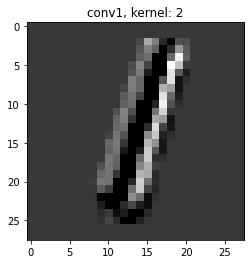

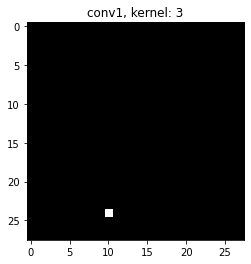

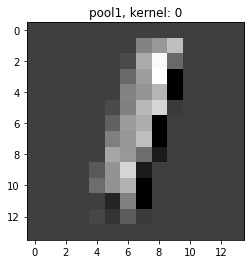

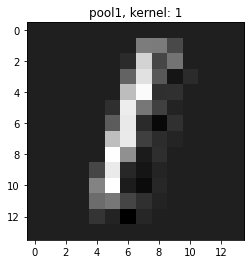

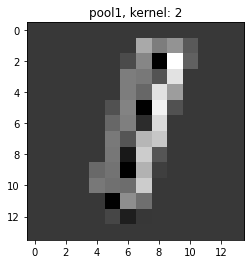

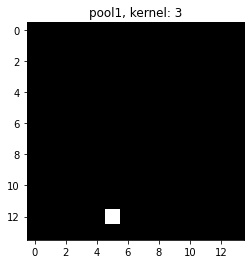

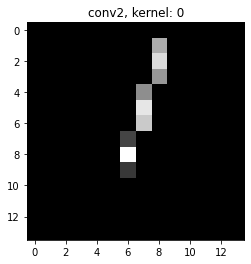

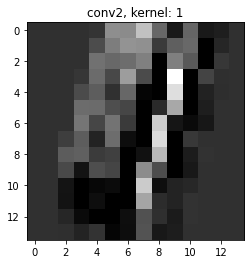

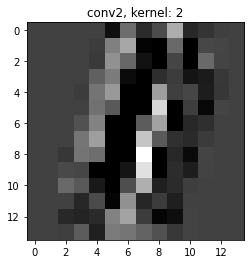

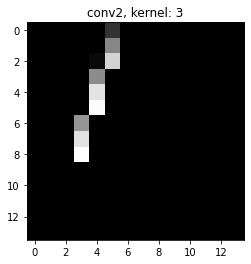

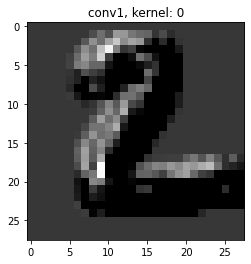

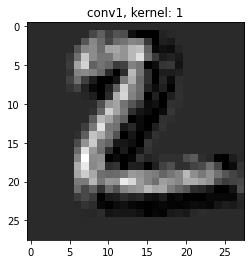

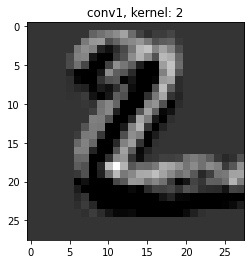

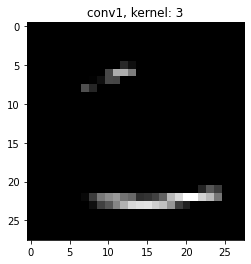

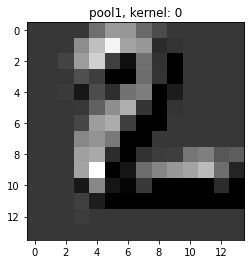

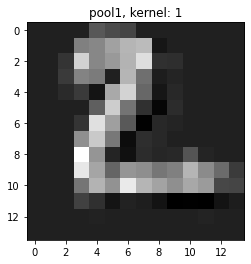

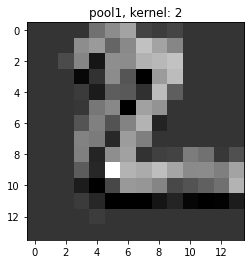

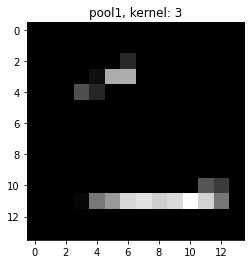

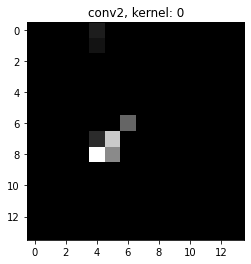

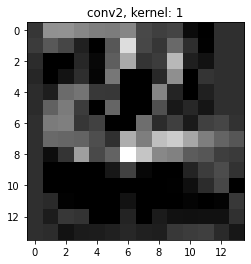

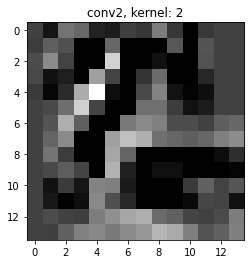

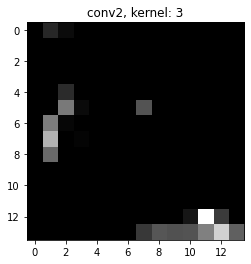

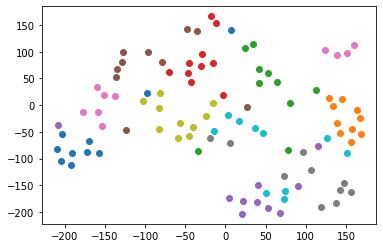

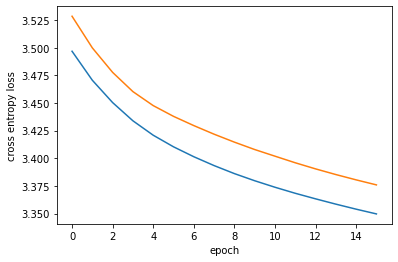

In [17]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 50
lr = 0.001

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        sgd(gradients, lr)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Below we implement the momentum algorithm.

In [18]:
def momentum(learning_rate, alpha):
    past_conv1 = np.zeros_like(model.conv1_weights)
    past_conv1_bias = np.zeros_like(model.conv1_bias)
    past_conv2 = np.zeros_like(model.conv2_weights)
    past_conv2_bias = np.zeros_like(model.conv2_bias)
    past_mlp = []
    past_mlp_bias = []
    for h in range(len(model.mlp.weights)):
        past_mlp.append(np.zeros_like(model.mlp.weights[h]))
        past_mlp_bias.append(np.zeros_like(model.mlp.bias[h]))

    while 1:
        update_conv1 = learning_rate*gradients[0] + alpha*past_conv1
        update_conv1_bias = learning_rate*gradients[1] + alpha*past_conv1_bias
        update_conv2 = learning_rate*gradients[2] + alpha*past_conv2
        update_conv2_bias = learning_rate*gradients[3] + alpha*past_conv2_bias
        update_mlp = []
        update_mlp_bias = []
        for h in range(len(gradients[4])):
            update_mlp.append(learning_rate*gradients[4][h] + alpha*past_mlp[h])
            update_mlp_bias.append(learning_rate*gradients[5][h] + alpha*past_mlp_bias[h])

        model.conv1_weights -= update_conv1
        model.conv1_bias -= update_conv1_bias
        model.conv2_weights -= update_conv2
        model.conv2_bias -= update_conv2_bias
        for h in range(len(gradients[4])):
            model.mlp.weights[h] -= update_mlp[h]
            model.mlp.bias[h] -= update_mlp_bias[h]

        past_conv1 = update_conv1
        past_conv1_bias = update_conv1_bias
        past_conv2 = update_conv2
        past_conv2_bias = update_conv2_bias
        past_mlp = update_mlp
        past_mlp_bias = update_mlp_bias
        yield

Below we train the CNN model using stochastic gradient descent with momentum. We experiment with batch size 5 and 50. We also visualize the activations after training on first and last epochs. I have chosen three images and visualized the activations after first convolution layer, first pooling layer and second convolution layer. So in total, 36 images are visualised after training on first epoch. After that, you can see the TSNE plot of bottleneck layer outputs. After that, another 36 images for activation maps after training on final epoch. Then you can see TSNE plot. Then you can see the plot of errors (cross-entropy error). Accuracy is reported after every epoch.

Currently training on epoch: 0


100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


Train accuracy = 0.771
Test accuracy = 0.72


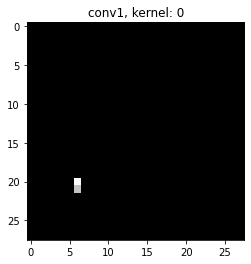

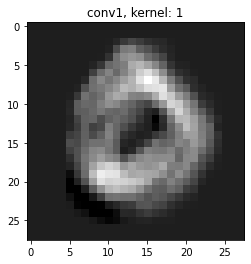

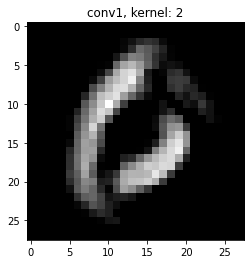

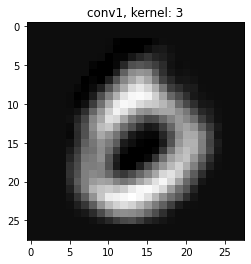

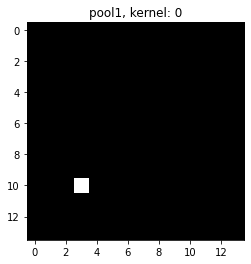

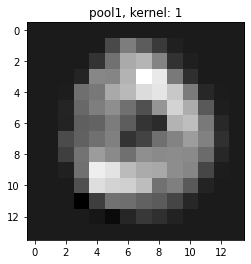

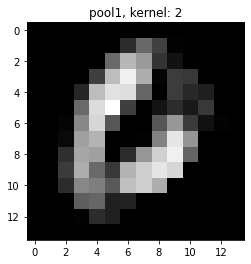

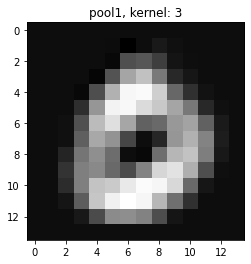

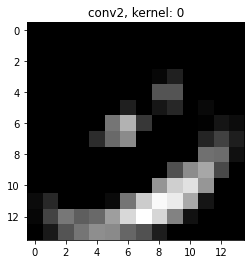

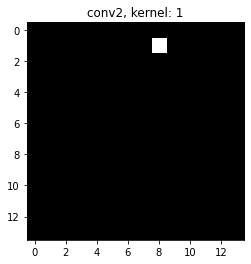

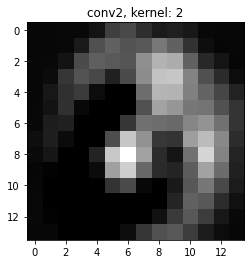

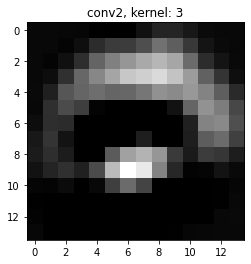

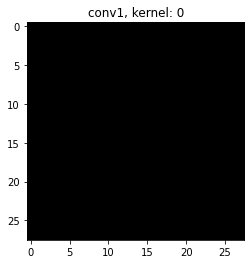

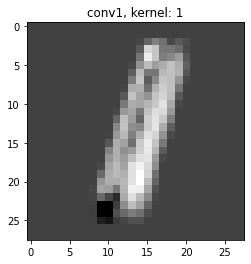

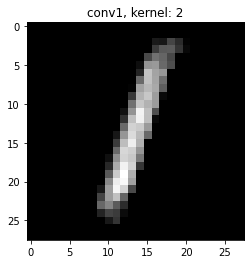

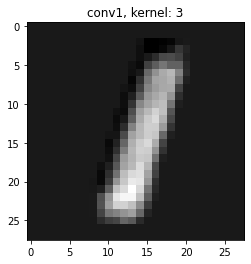

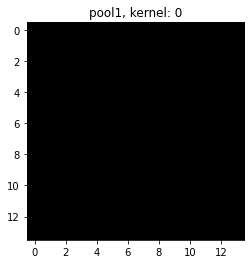

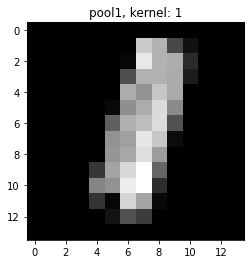

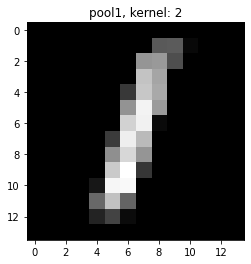

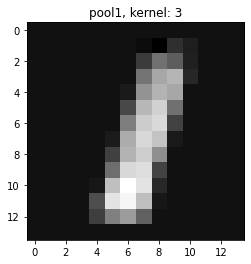

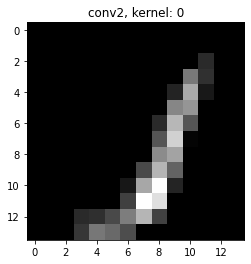

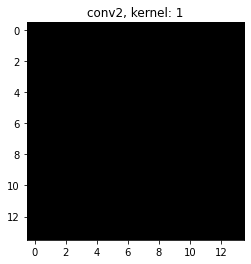

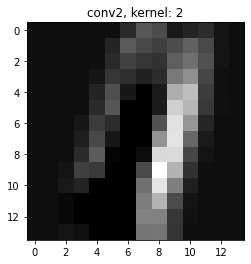

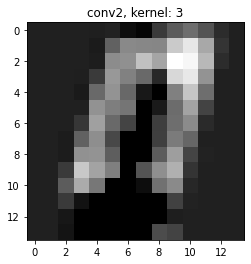

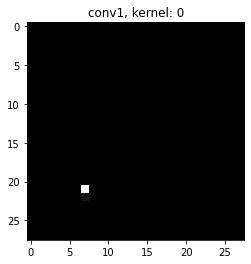

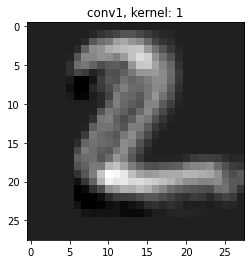

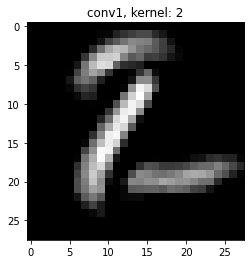

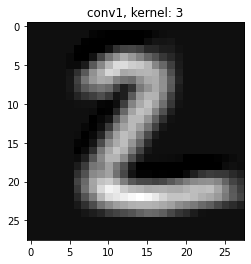

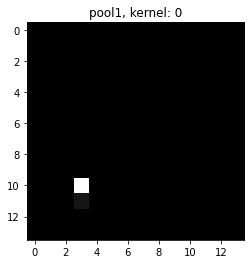

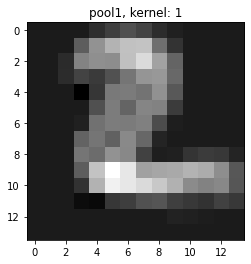

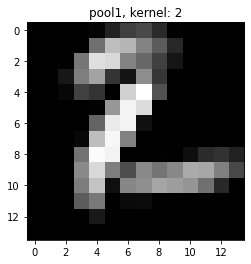

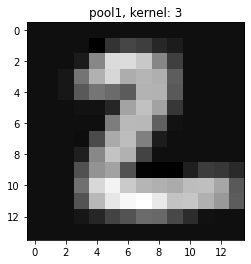

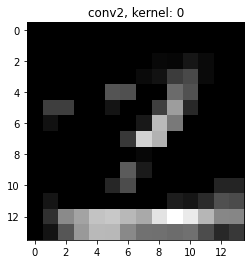

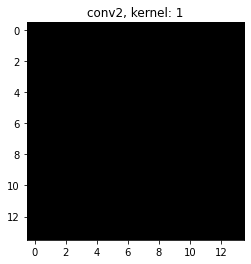

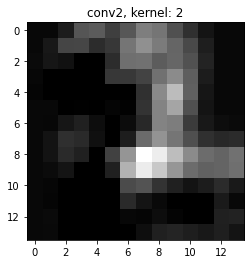

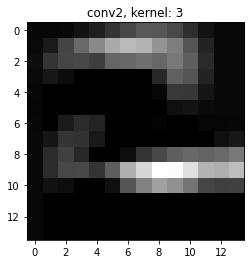

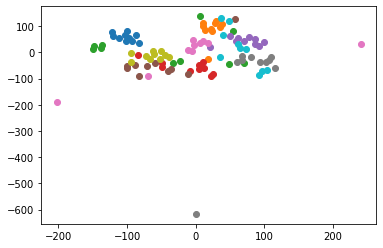

Currently training on epoch: 1


100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


Train accuracy = 0.865
Test accuracy = 0.83
Currently training on epoch: 2


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train accuracy = 0.921
Test accuracy = 0.87
Currently training on epoch: 3


100%|██████████| 200/200 [01:24<00:00,  2.38it/s]


Train accuracy = 0.888
Test accuracy = 0.82
Currently training on epoch: 4


100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


Train accuracy = 0.946
Test accuracy = 0.86
Currently training on epoch: 5


100%|██████████| 200/200 [01:22<00:00,  2.41it/s]


Train accuracy = 0.948
Test accuracy = 0.95
Currently training on epoch: 6


100%|██████████| 200/200 [01:30<00:00,  2.21it/s]


Train accuracy = 0.962
Test accuracy = 0.96
Currently training on epoch: 7


100%|██████████| 200/200 [01:31<00:00,  2.18it/s]


Train accuracy = 0.971
Test accuracy = 0.97
Currently training on epoch: 8


100%|██████████| 200/200 [01:30<00:00,  2.22it/s]


Train accuracy = 0.978
Test accuracy = 0.97
Currently training on epoch: 9


100%|██████████| 200/200 [01:31<00:00,  2.19it/s]


Train accuracy = 0.979
Test accuracy = 0.96
Currently training on epoch: 10


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Train accuracy = 0.982
Test accuracy = 0.97
Currently training on epoch: 11


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Train accuracy = 0.971
Test accuracy = 0.93
Currently training on epoch: 12


100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


Train accuracy = 0.967
Test accuracy = 0.92
Currently training on epoch: 13


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Train accuracy = 0.988
Test accuracy = 0.98
Currently training on epoch: 14


100%|██████████| 200/200 [01:34<00:00,  2.13it/s]


Train accuracy = 0.992
Test accuracy = 0.96


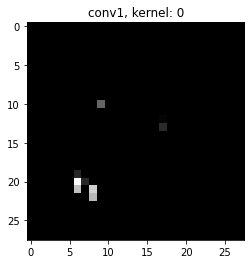

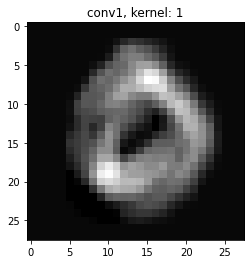

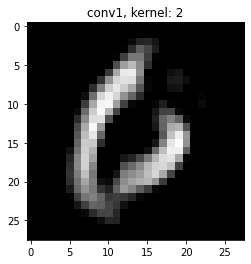

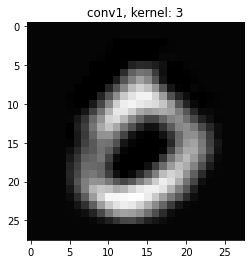

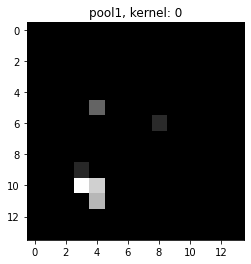

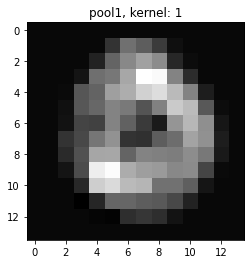

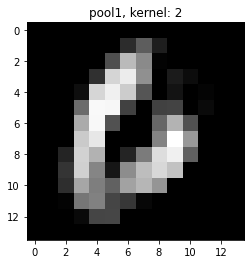

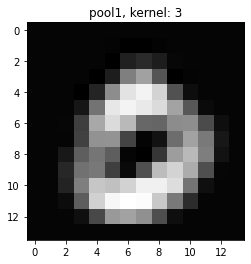

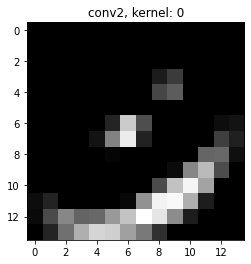

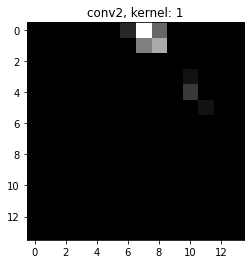

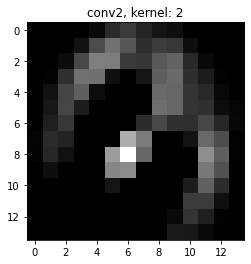

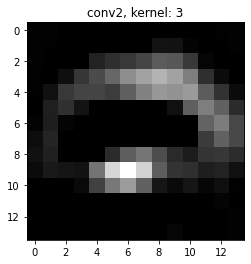

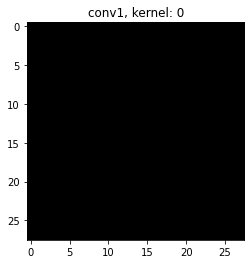

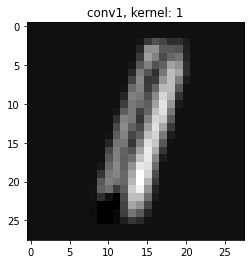

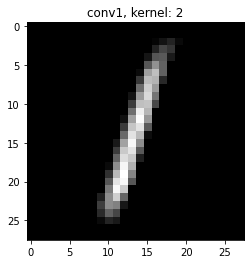

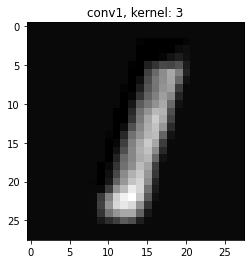

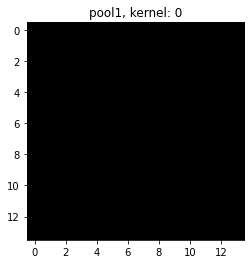

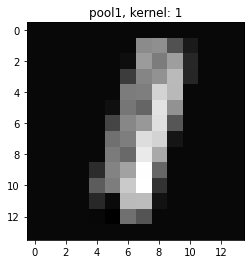

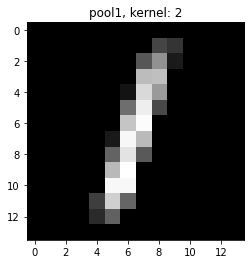

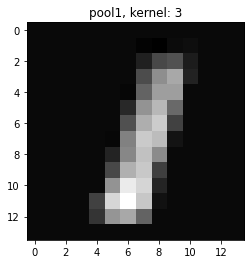

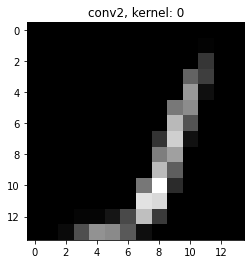

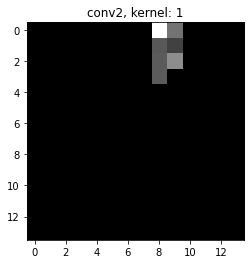

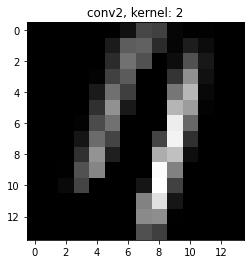

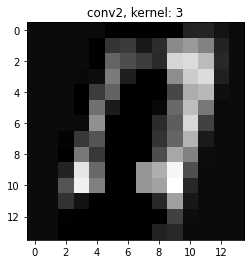

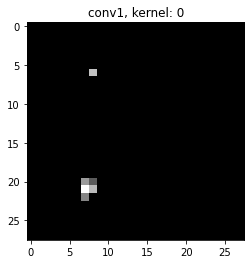

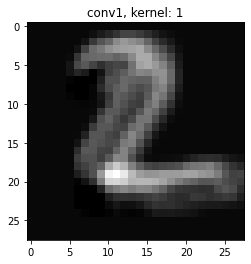

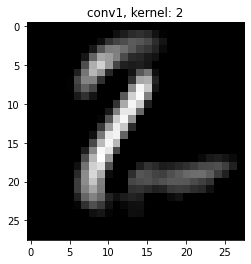

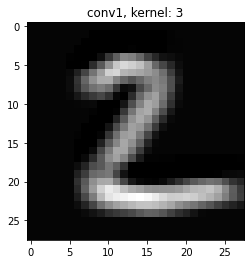

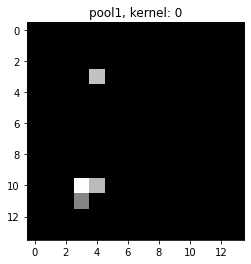

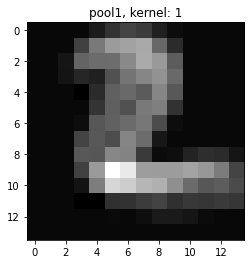

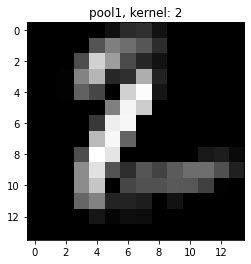

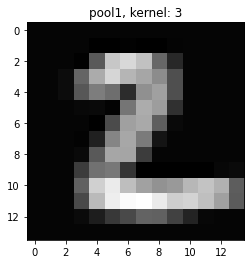

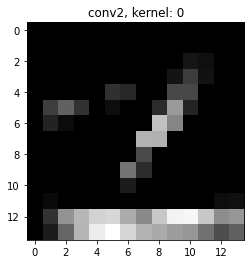

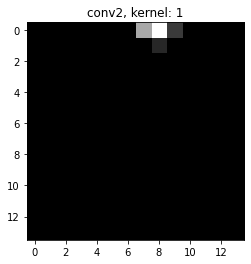

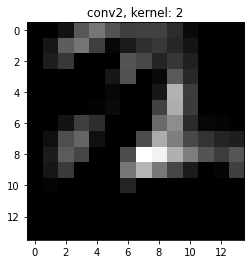

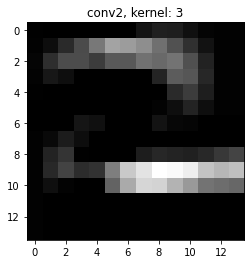

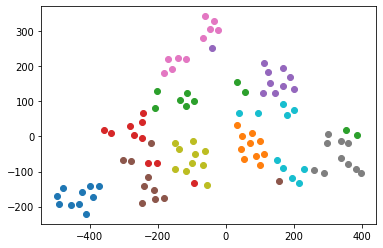

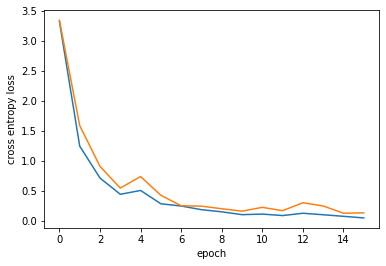

In [19]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 5
lr = 0.001
momentum_ = 0.9

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]

opt = momentum(lr, momentum_)

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        next(opt)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Initial training loss: 3.438808892145756
Initial validation loss: 3.435386848967064
Currently training on epoch: 0


100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


Train accuracy = 0.113
Test accuracy = 0.12


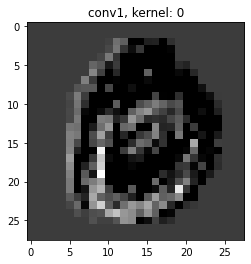

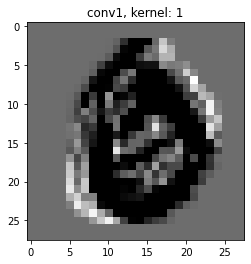

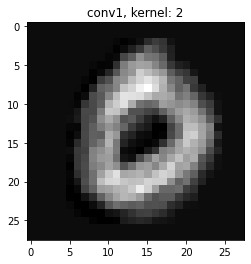

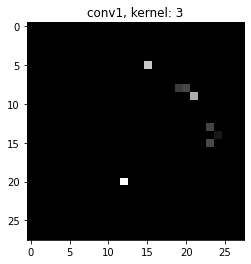

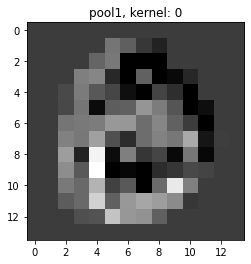

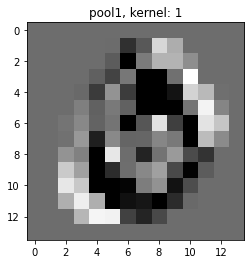

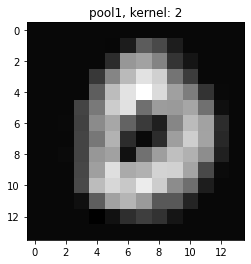

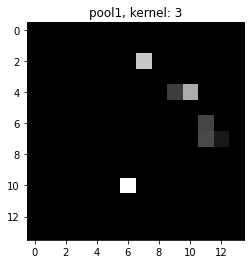

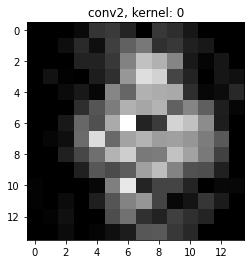

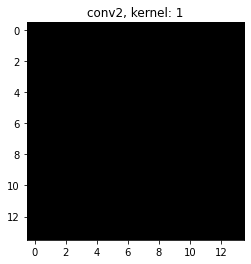

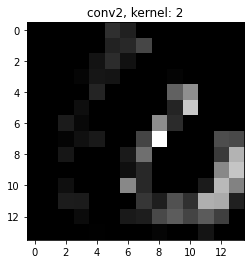

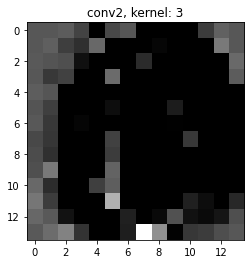

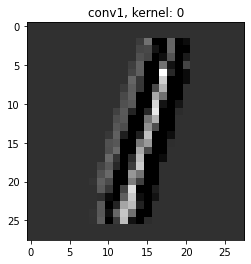

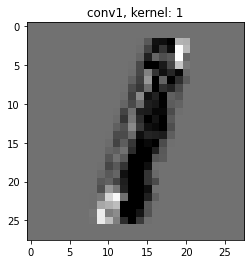

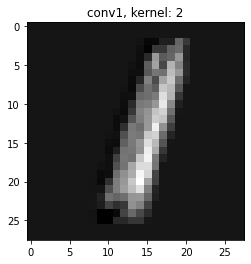

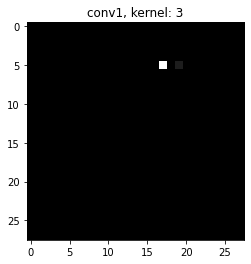

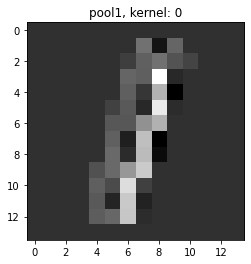

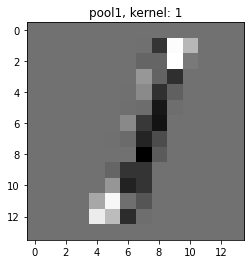

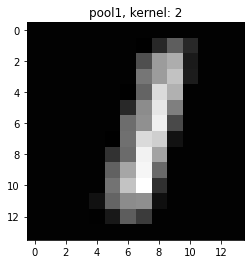

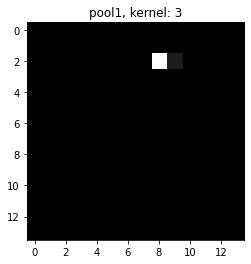

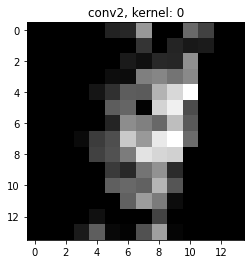

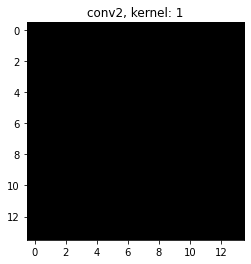

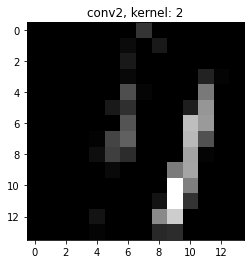

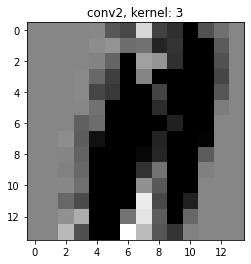

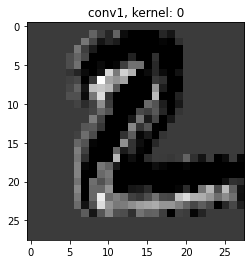

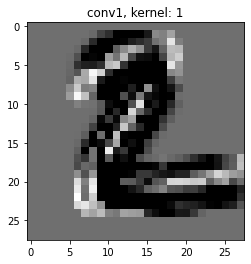

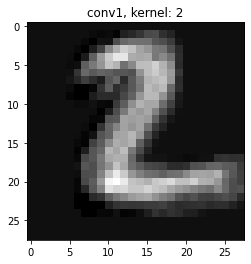

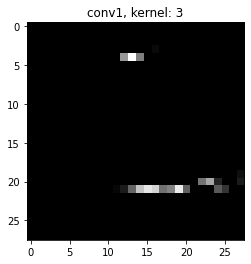

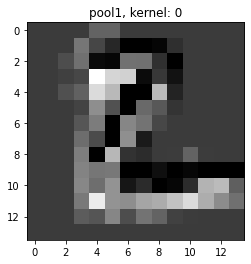

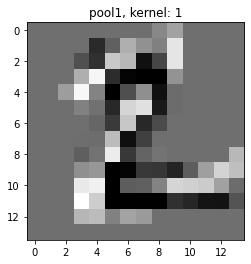

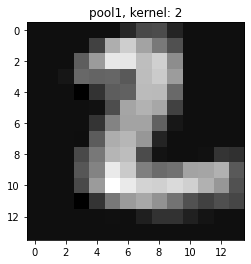

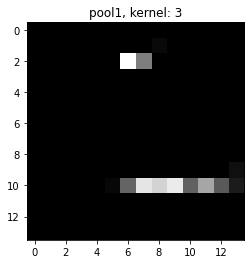

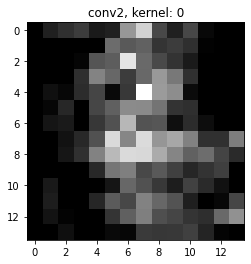

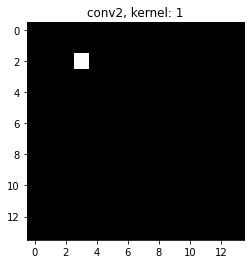

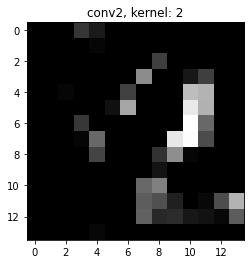

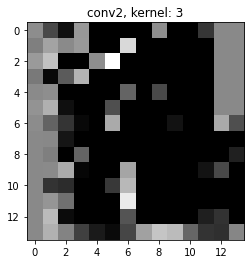

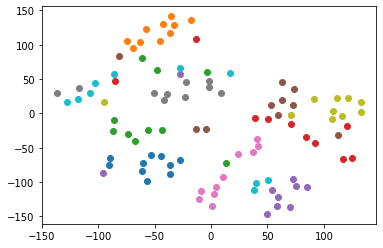

Currently training on epoch: 1


100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Train accuracy = 0.152
Test accuracy = 0.16
Currently training on epoch: 2


100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


Train accuracy = 0.211
Test accuracy = 0.2
Currently training on epoch: 3


100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


Train accuracy = 0.265
Test accuracy = 0.24
Currently training on epoch: 4


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


Train accuracy = 0.348
Test accuracy = 0.36
Currently training on epoch: 5


100%|██████████| 20/20 [01:20<00:00,  4.02s/it]


Train accuracy = 0.413
Test accuracy = 0.42
Currently training on epoch: 6


100%|██████████| 20/20 [01:19<00:00,  4.00s/it]


Train accuracy = 0.527
Test accuracy = 0.5
Currently training on epoch: 7


100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


Train accuracy = 0.641
Test accuracy = 0.59
Currently training on epoch: 8


100%|██████████| 20/20 [01:19<00:00,  3.95s/it]


Train accuracy = 0.699
Test accuracy = 0.62
Currently training on epoch: 9


100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


Train accuracy = 0.773
Test accuracy = 0.73
Currently training on epoch: 10


100%|██████████| 20/20 [01:18<00:00,  3.95s/it]


Train accuracy = 0.793
Test accuracy = 0.78
Currently training on epoch: 11


100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


Train accuracy = 0.814
Test accuracy = 0.74
Currently training on epoch: 12


100%|██████████| 20/20 [01:19<00:00,  3.99s/it]


Train accuracy = 0.837
Test accuracy = 0.78
Currently training on epoch: 13


100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train accuracy = 0.811
Test accuracy = 0.8
Currently training on epoch: 14


100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Train accuracy = 0.86
Test accuracy = 0.81


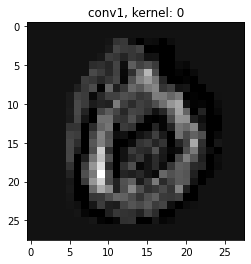

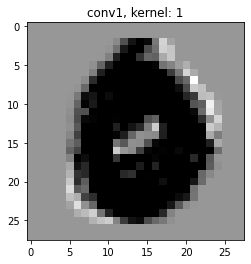

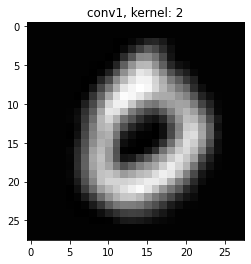

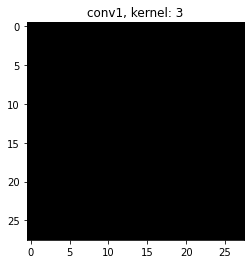

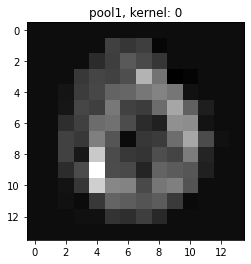

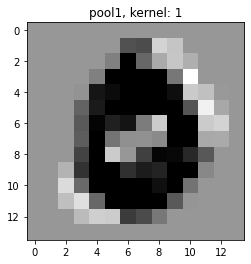

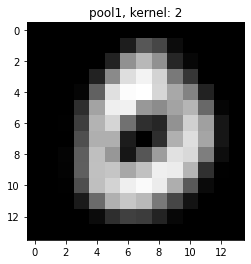

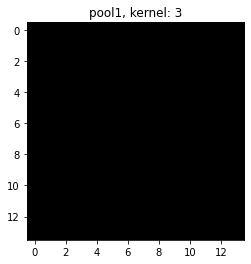

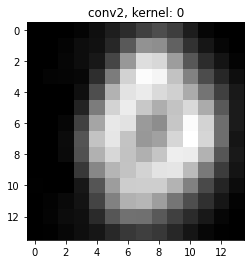

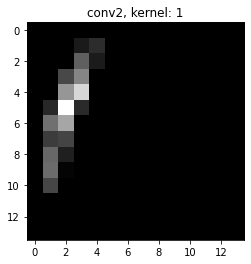

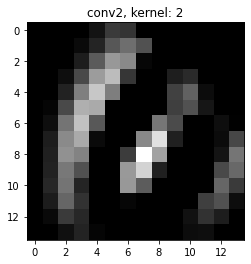

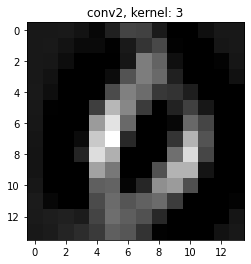

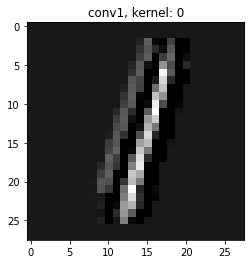

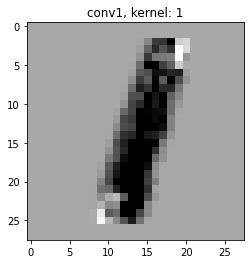

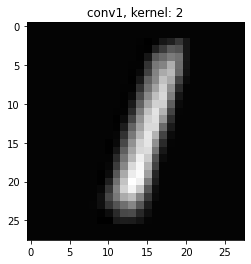

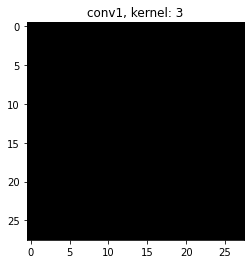

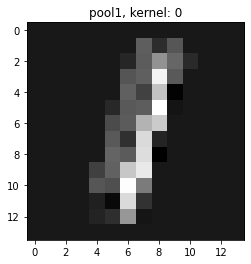

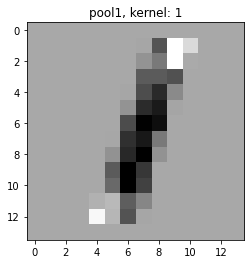

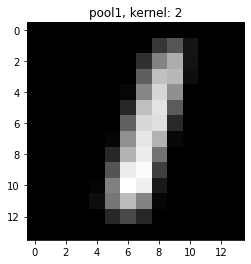

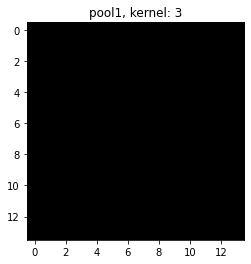

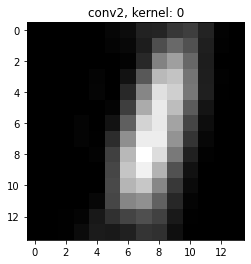

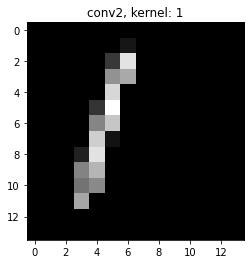

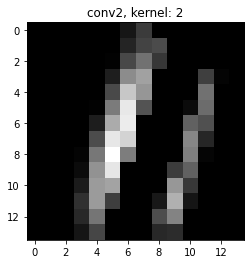

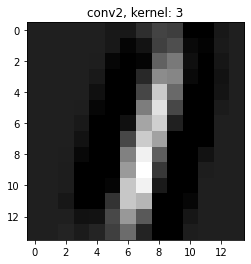

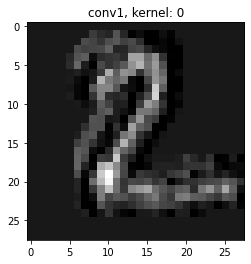

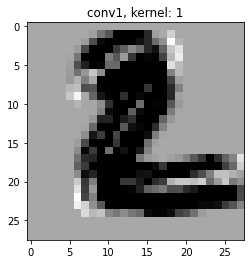

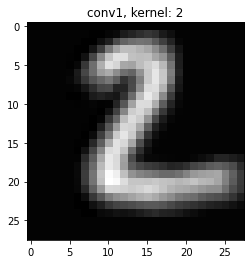

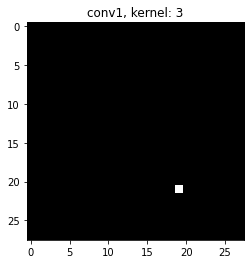

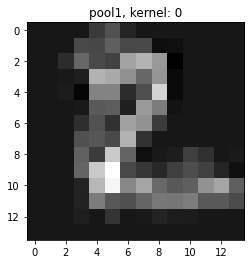

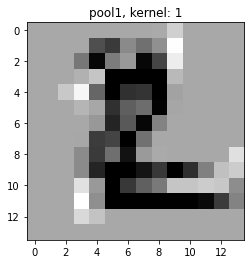

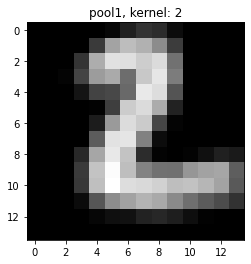

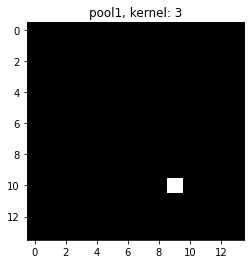

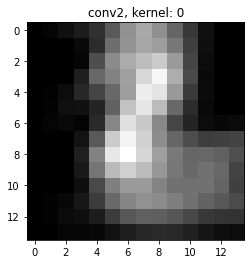

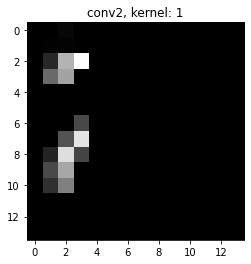

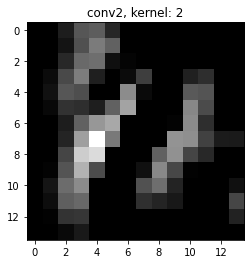

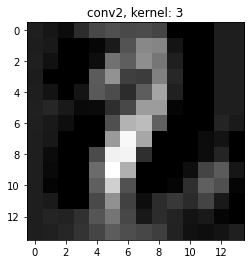

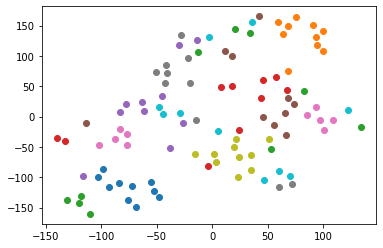

Final training loss: 0.7144121683977612
Final validation loss: 0.9030697013169737


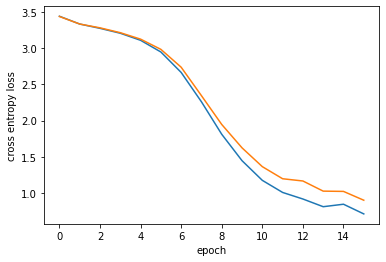

In [20]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 50
lr = 0.001
momentum_ = 0.9

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]
print("Initial training loss:", loss_train[0])
print("Initial validation loss:", loss_test[0])

opt = momentum(lr, momentum_)

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        next(opt)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

print("Final training loss:", loss_train[-1])
print("Final validation loss:", loss_test[-1])

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Below we implement the rmsprop algorithm.

In [15]:
def rmsprop(learning_rate, rho):
    epsilon = 1e-9
    past_conv1 = np.zeros_like(model.conv1_weights)
    past_conv1_bias = np.zeros_like(model.conv1_bias)
    past_conv2 = np.zeros_like(model.conv2_weights)
    past_conv2_bias = np.zeros_like(model.conv2_bias)
    past_mlp = []
    past_mlp_bias = []
    for h in range(len(model.mlp.weights)):
        past_mlp.append(np.zeros_like(model.mlp.weights[h]))
        past_mlp_bias.append(np.zeros_like(model.mlp.bias[h]))

    while 1:
        update_conv1 = (1-rho)*(gradients[0]**2) + rho*past_conv1
        update_conv1_bias = (1-rho)*(gradients[1]**2) + rho*past_conv1_bias
        update_conv2 = (1-rho)*(gradients[2]**2) + rho*past_conv2
        update_conv2_bias = (1-rho)*(gradients[3]**2) + rho*past_conv2_bias
        update_mlp = []
        update_mlp_bias = []
        for h in range(len(gradients[4])):
            update_mlp.append((1-rho)*(gradients[4][h]**2) + rho*past_mlp[h])
            update_mlp_bias.append((1-rho)*(gradients[5][h]**2) + rho*past_mlp_bias[h])

        model.conv1_weights -= learning_rate*gradients[0]/((update_conv1+epsilon)**0.5)
        model.conv1_bias -= learning_rate*gradients[1]/((update_conv1_bias+epsilon)**0.5)
        model.conv2_weights -= learning_rate*gradients[2]/((update_conv2+epsilon)**0.5)
        model.conv2_bias -= learning_rate*gradients[3]/((update_conv2_bias+epsilon)**0.5)
        for h in range(len(gradients[4])):
            model.mlp.weights[h] -= learning_rate*gradients[4][h]/((update_mlp[h]+epsilon)**0.5)
            model.mlp.bias[h] -= learning_rate*gradients[5][h]/((update_mlp_bias[h]+epsilon)**0.5)

        past_conv1 = update_conv1
        past_conv1_bias = update_conv1_bias
        past_conv2 = update_conv2
        past_conv2_bias = update_conv2_bias
        past_mlp = update_mlp
        past_mlp_bias = update_mlp_bias
        yield

Below we train the CNN model using RMSprop. We experiment with batch size 5 and 50. We also visualize the activations after training on first and last epochs. I have chosen three images and visualized the activations after first convolution layer, first pooling layer and second convolution layer. So in total, 36 images are visualised after training on first epoch. After that, you can see the TSNE plot of bottleneck layer outputs. After that, another 36 images for activation maps after training on final epoch. Then you can see TSNE plot. Then you can see the plot of errors (cross-entropy error). Accuracy is reported after every epoch.

Currently training on epoch: 0


100%|██████████| 200/200 [01:26<00:00,  2.30it/s]


Train accuracy = 0.68
Test accuracy = 0.57


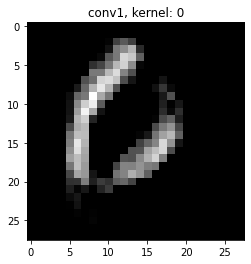

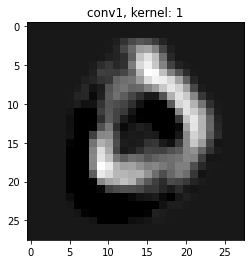

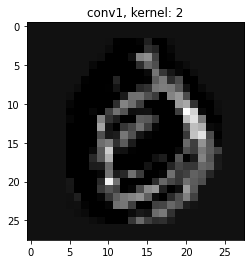

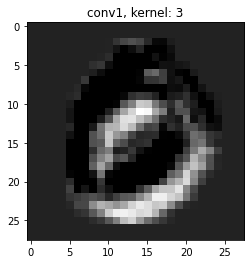

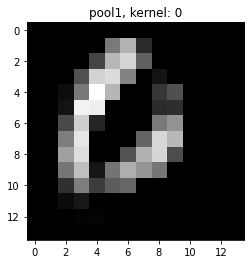

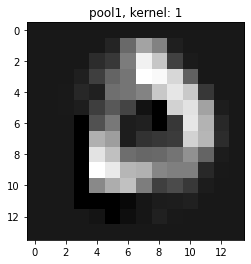

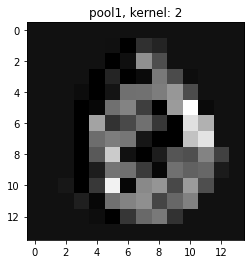

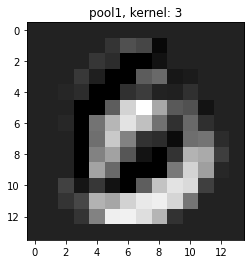

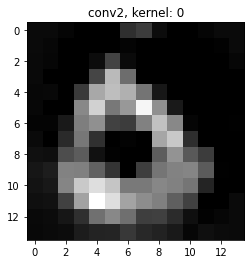

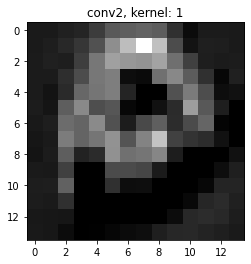

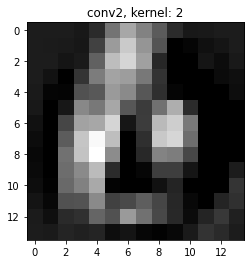

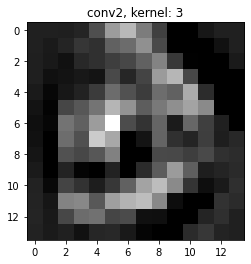

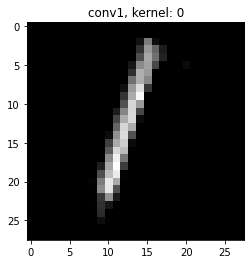

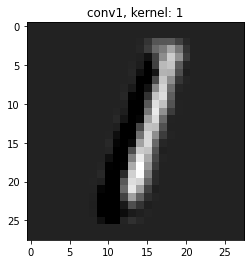

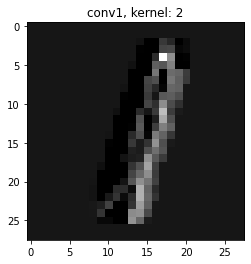

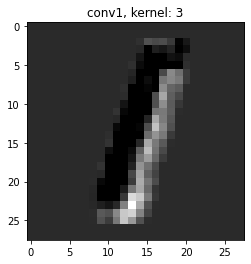

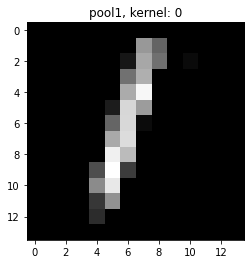

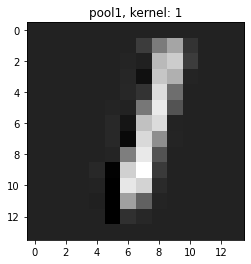

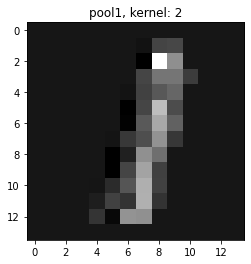

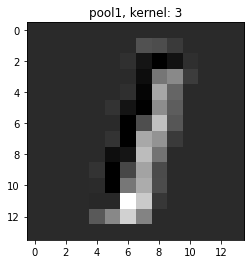

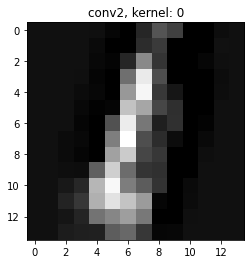

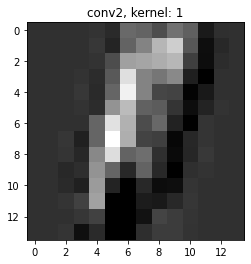

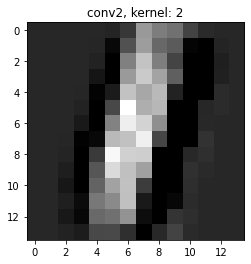

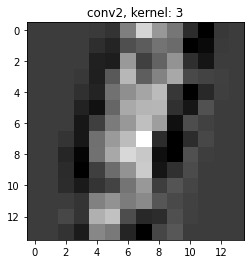

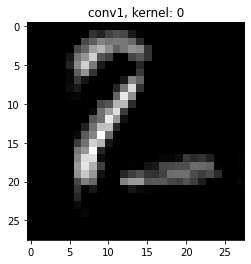

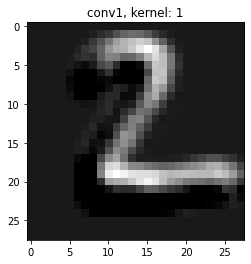

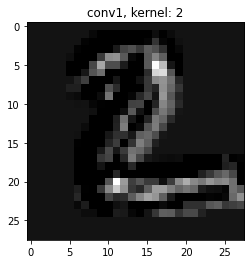

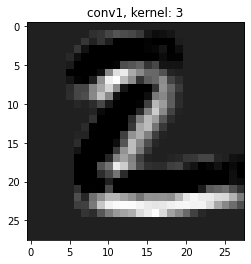

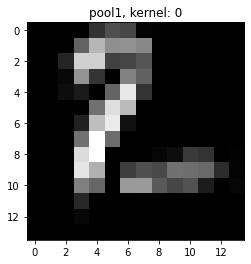

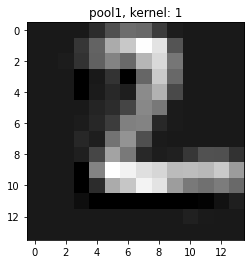

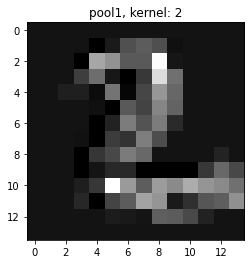

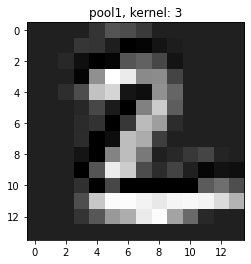

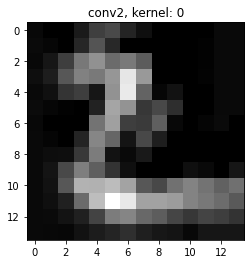

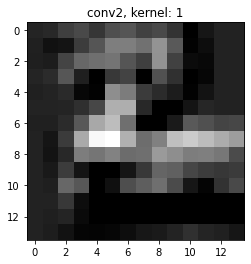

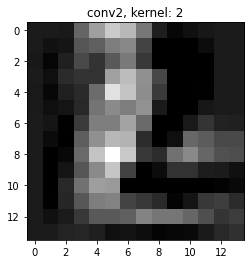

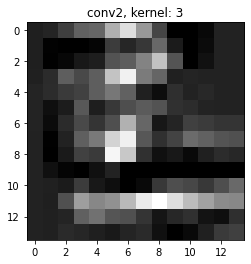

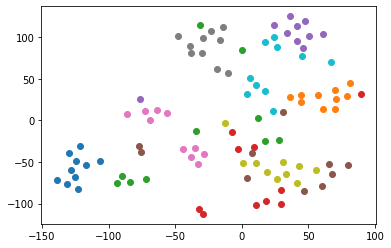

Currently training on epoch: 1


100%|██████████| 200/200 [01:26<00:00,  2.32it/s]


Train accuracy = 0.819
Test accuracy = 0.75
Currently training on epoch: 2


100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


Train accuracy = 0.849
Test accuracy = 0.78
Currently training on epoch: 3


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


Train accuracy = 0.89
Test accuracy = 0.85
Currently training on epoch: 4


100%|██████████| 200/200 [01:28<00:00,  2.27it/s]


Train accuracy = 0.915
Test accuracy = 0.86
Currently training on epoch: 5


100%|██████████| 200/200 [01:27<00:00,  2.29it/s]


Train accuracy = 0.922
Test accuracy = 0.87
Currently training on epoch: 6


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


Train accuracy = 0.928
Test accuracy = 0.88
Currently training on epoch: 7


100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


Train accuracy = 0.945
Test accuracy = 0.96
Currently training on epoch: 8


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train accuracy = 0.973
Test accuracy = 0.96
Currently training on epoch: 9


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Train accuracy = 0.944
Test accuracy = 0.95
Currently training on epoch: 10


100%|██████████| 200/200 [01:27<00:00,  2.29it/s]


Train accuracy = 0.983
Test accuracy = 0.97
Currently training on epoch: 11


100%|██████████| 200/200 [01:26<00:00,  2.31it/s]


Train accuracy = 0.979
Test accuracy = 0.99
Currently training on epoch: 12


100%|██████████| 200/200 [01:21<00:00,  2.46it/s]


Train accuracy = 0.971
Test accuracy = 0.92
Currently training on epoch: 13


100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


Train accuracy = 0.977
Test accuracy = 0.9
Currently training on epoch: 14


100%|██████████| 200/200 [01:21<00:00,  2.45it/s]


Train accuracy = 0.99
Test accuracy = 0.97


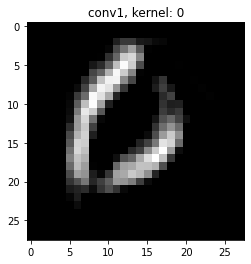

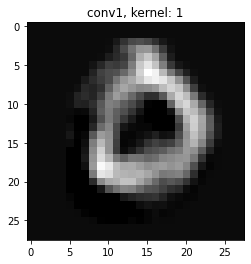

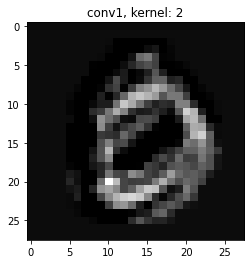

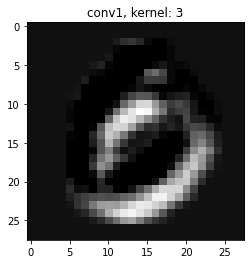

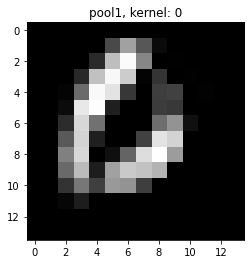

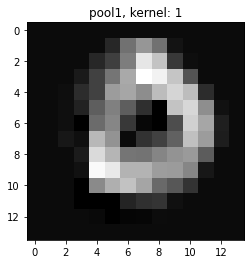

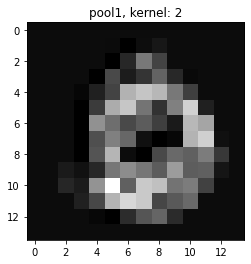

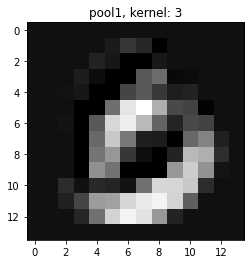

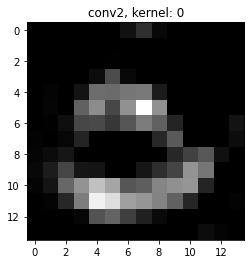

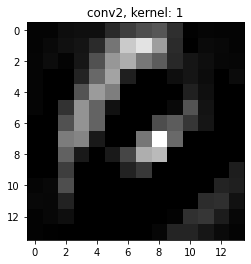

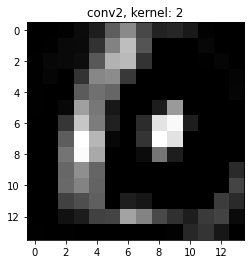

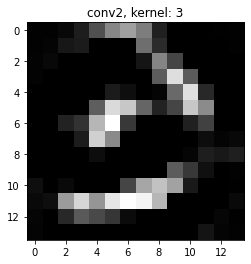

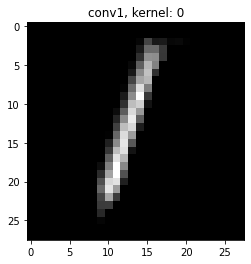

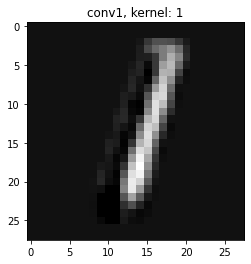

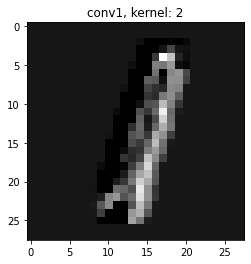

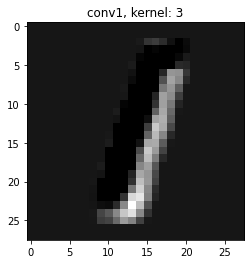

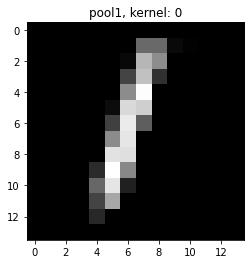

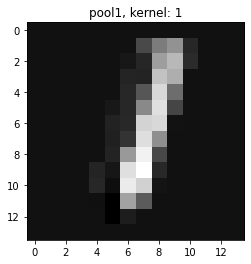

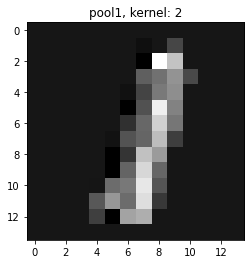

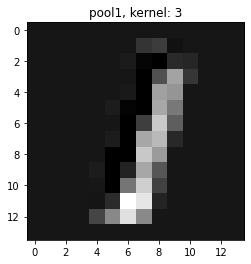

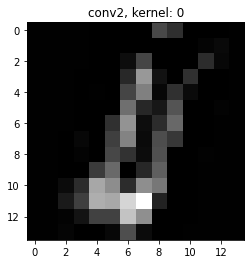

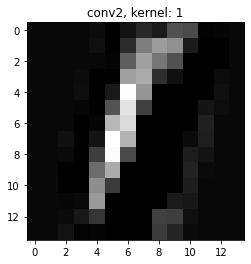

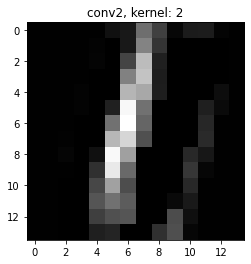

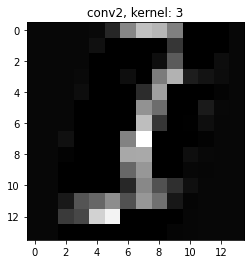

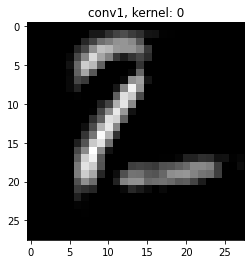

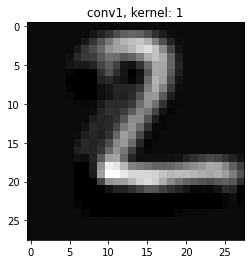

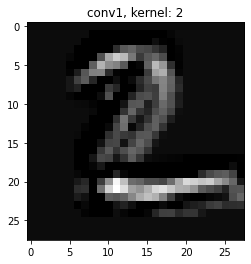

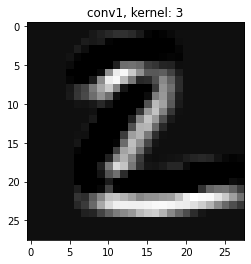

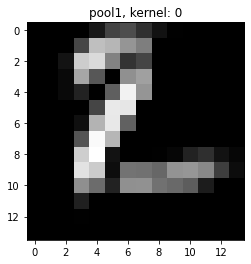

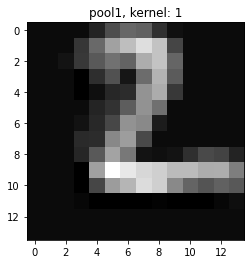

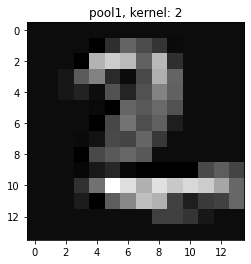

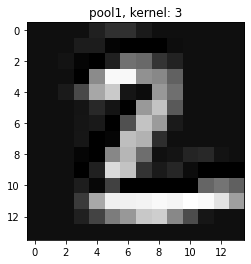

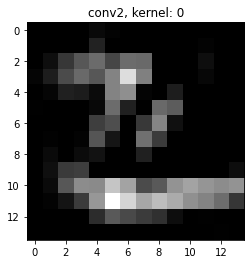

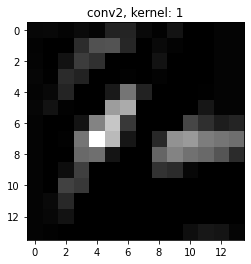

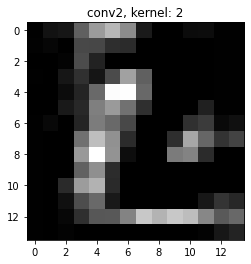

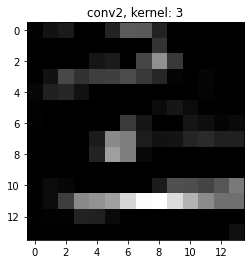

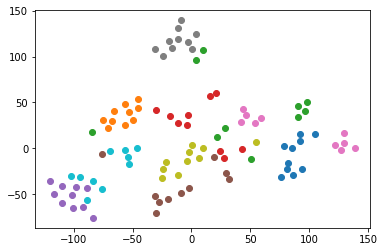

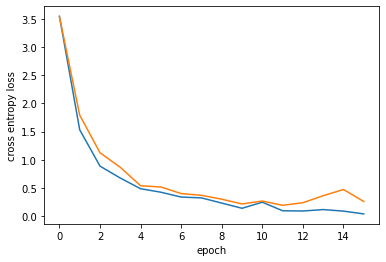

In [16]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 5
lr = 0.001
rho_ = 0.9

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]

opt = rmsprop(lr, rho_)

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        next(opt)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0


100%|██████████| 20/20 [01:16<00:00,  3.80s/it]


Train accuracy = 0.515
Test accuracy = 0.47


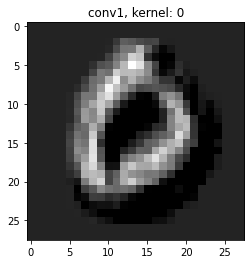

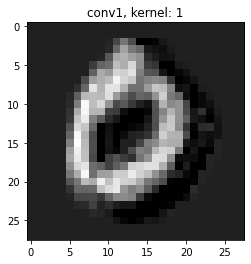

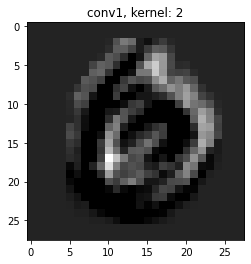

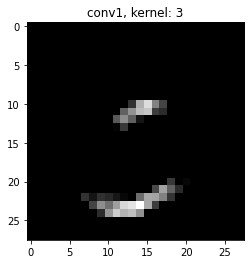

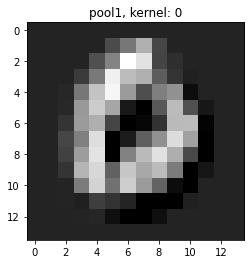

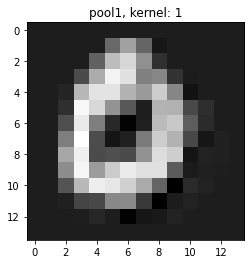

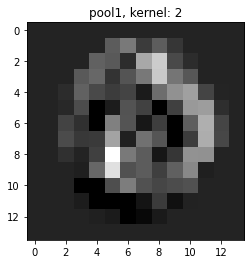

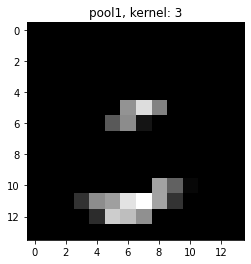

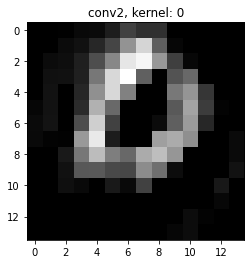

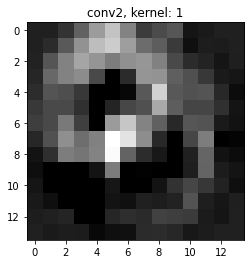

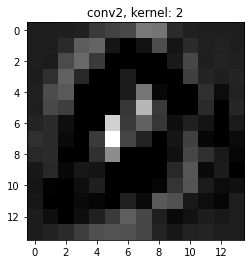

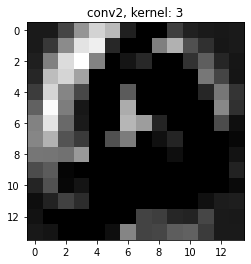

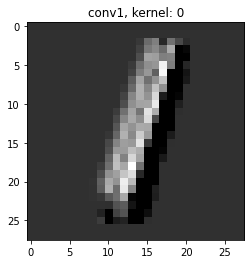

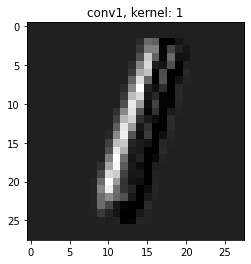

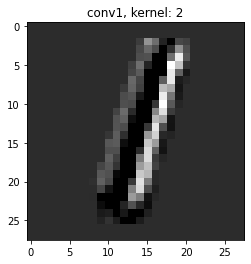

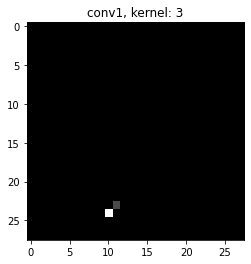

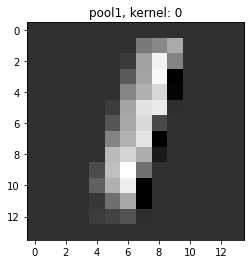

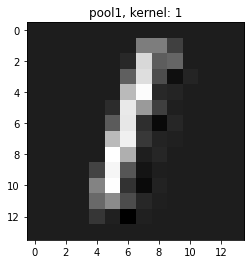

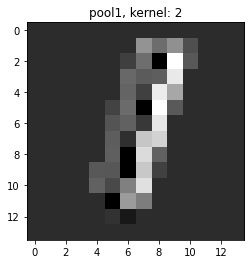

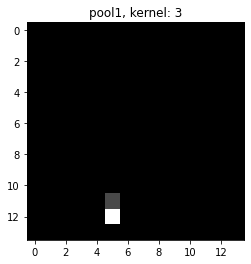

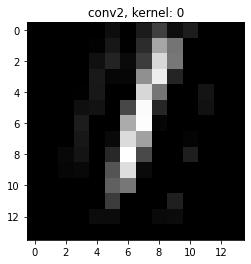

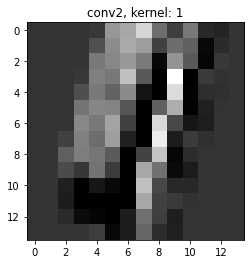

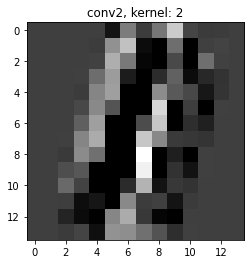

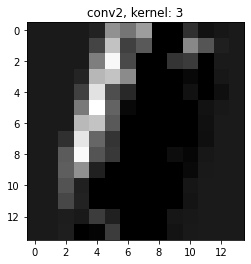

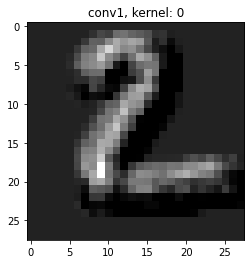

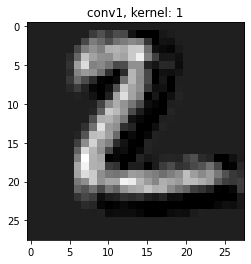

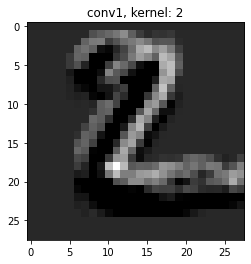

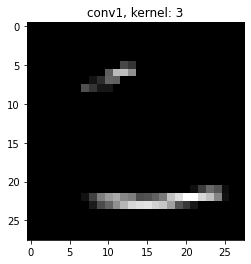

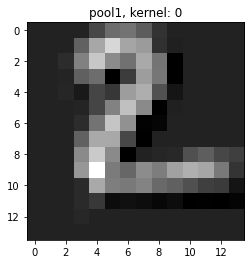

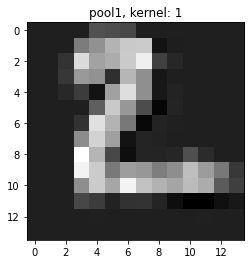

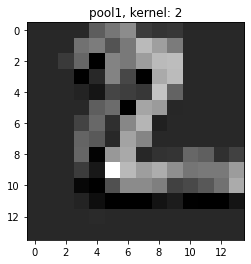

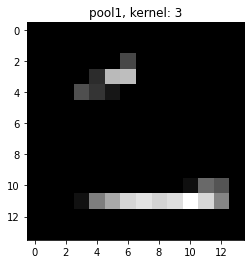

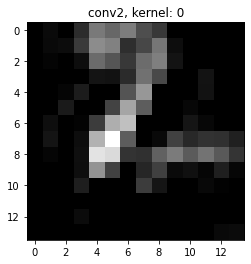

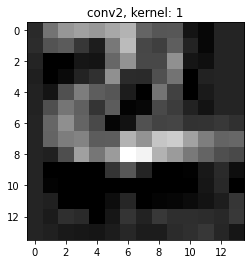

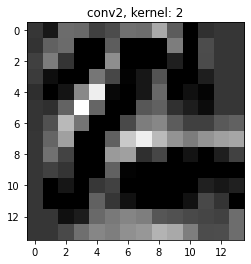

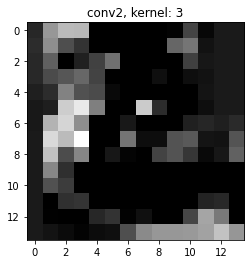

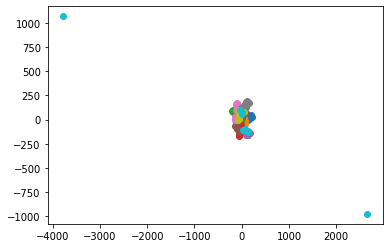

Currently training on epoch: 1


100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


Train accuracy = 0.661
Test accuracy = 0.54
Currently training on epoch: 2


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Train accuracy = 0.785
Test accuracy = 0.69
Currently training on epoch: 3


100%|██████████| 20/20 [01:21<00:00,  4.10s/it]


Train accuracy = 0.811
Test accuracy = 0.77
Currently training on epoch: 4


100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Train accuracy = 0.854
Test accuracy = 0.79
Currently training on epoch: 5


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


Train accuracy = 0.873
Test accuracy = 0.81
Currently training on epoch: 6


100%|██████████| 20/20 [01:15<00:00,  3.77s/it]


Train accuracy = 0.877
Test accuracy = 0.8
Currently training on epoch: 7


100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


Train accuracy = 0.893
Test accuracy = 0.87
Currently training on epoch: 8


100%|██████████| 20/20 [01:15<00:00,  3.79s/it]


Train accuracy = 0.911
Test accuracy = 0.87
Currently training on epoch: 9


100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Train accuracy = 0.918
Test accuracy = 0.89
Currently training on epoch: 10


100%|██████████| 20/20 [01:15<00:00,  3.76s/it]


Train accuracy = 0.906
Test accuracy = 0.89
Currently training on epoch: 11


100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


Train accuracy = 0.933
Test accuracy = 0.9
Currently training on epoch: 12


100%|██████████| 20/20 [01:14<00:00,  3.75s/it]


Train accuracy = 0.947
Test accuracy = 0.89
Currently training on epoch: 13


100%|██████████| 20/20 [01:17<00:00,  3.89s/it]


Train accuracy = 0.959
Test accuracy = 0.94
Currently training on epoch: 14


100%|██████████| 20/20 [01:17<00:00,  3.88s/it]


Train accuracy = 0.953
Test accuracy = 0.94


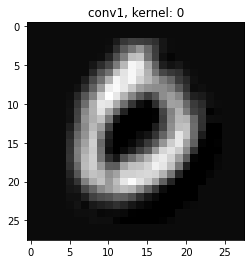

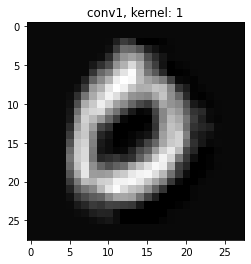

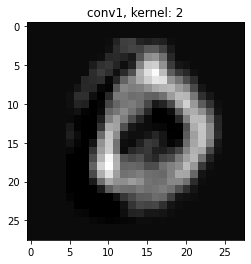

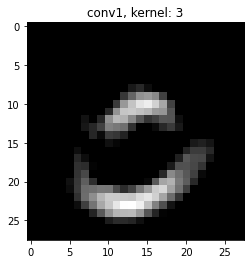

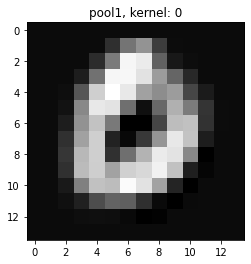

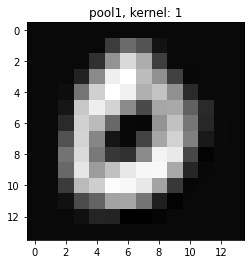

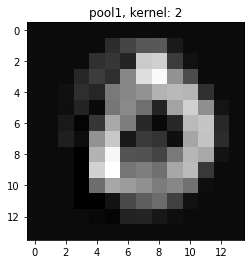

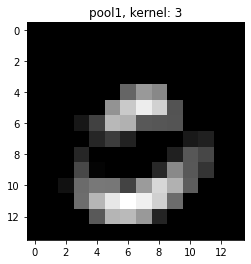

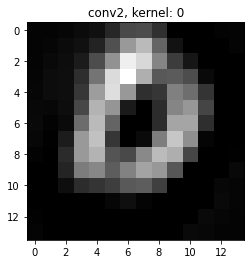

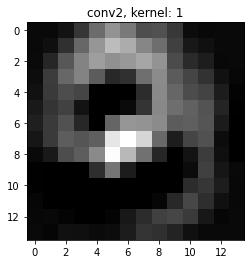

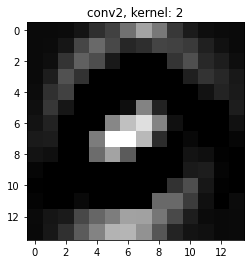

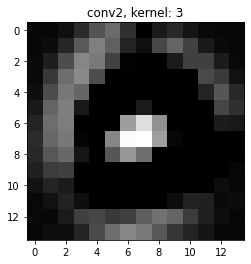

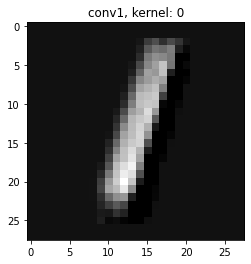

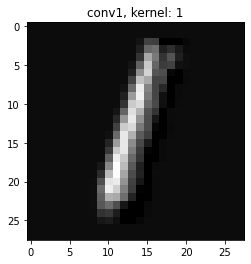

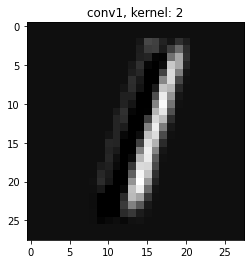

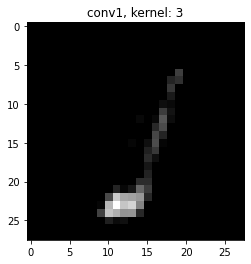

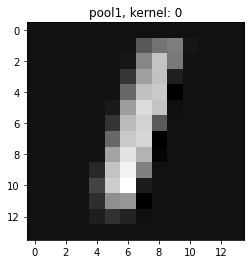

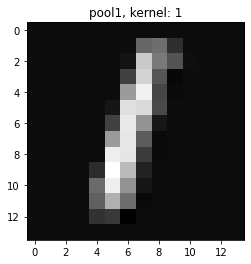

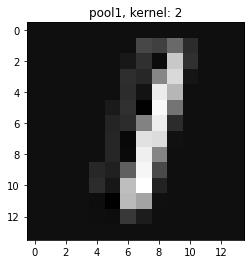

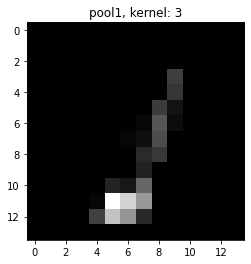

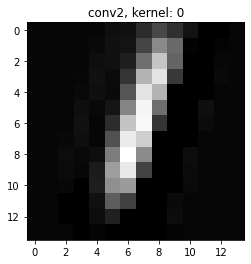

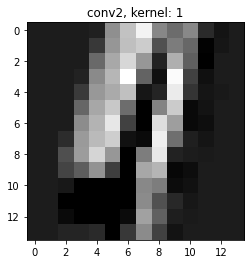

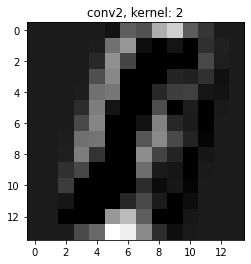

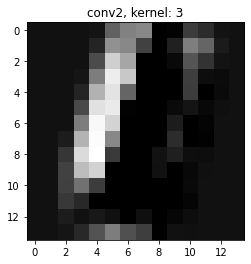

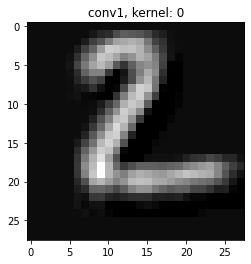

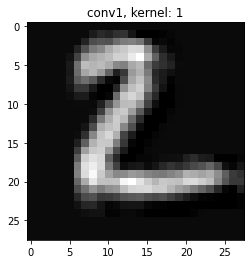

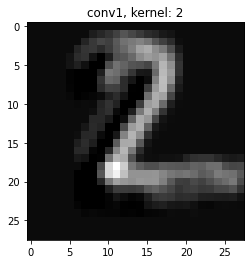

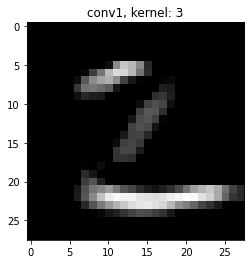

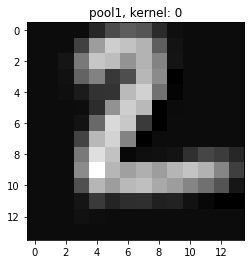

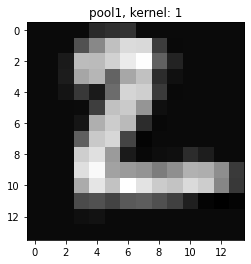

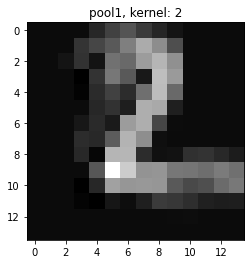

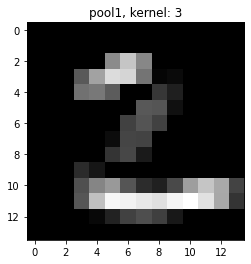

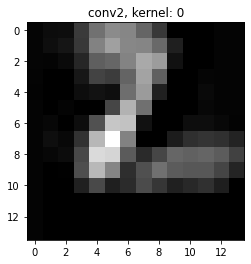

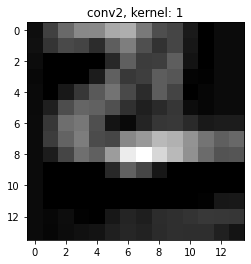

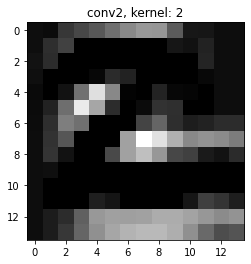

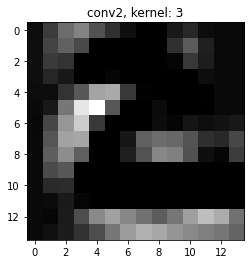

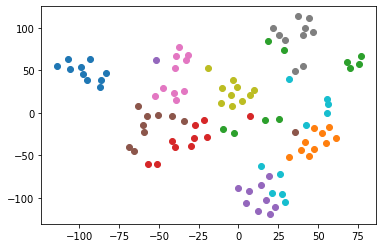

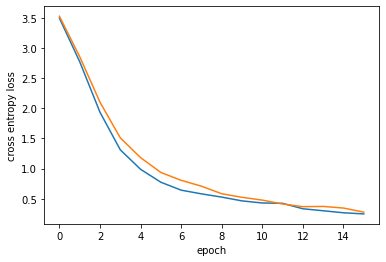

In [17]:
model = CNN(10, 14*14, [49])

epochs = 15
minibatch = 50
lr = 0.001
rho_ = 0.9

loss_train = [CrossEntropyLoss(labs, model.forward(dat)[0])]
loss_test = [CrossEntropyLoss(test_labs, model.forward(test)[0])]

opt = rmsprop(lr, rho_)

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in tqdm(range(dat.shape[0]//minibatch)):
        preds, cache = model.forward(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        back = np.zeros_like(preds)
        back += preds
        back[np.arange(preds.shape[0]), labs[indices[j*minibatch:(j+1)*minibatch]]] -= 1
        back /= np.log(2)
        gradients = model.backward(back, cache, dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        next(opt)
    preds__, _ = model.forward(dat)
    loss_train.append(CrossEntropyLoss(labs, preds__))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__, activations = model.forward(test)
    loss_test.append(CrossEntropyLoss(test_labs, preds__))
    print("Test accuracy =", accuracy(test_labs, preds__))
    if i == 0 or i == epochs-1:
        for o in range(3):
            for e in range(4):
                plt.imshow(np.transpose(activations[0][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[1][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("pool1, kernel: "+str(e))
                plt.show()
            for e in range(4):
                plt.imshow(np.transpose(activations[2][10*o], (1,2,0))[:, :, e], cmap='gray')
                plt.title("conv2, kernel: "+str(e))
                plt.show()
        a = TSNE(n_components=2, init='random', perplexity=10, n_iter=10000).fit_transform(np.array(activations[3]))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()